In [ ]:
from __future__ import absolute_import, division, print_function

In [ ]:
# License: MIT

# Clustering experiments for JRA-55 geopotential height anomalies

In this notebook we compare the performance of $k$-means, archetypal analysis, and
regularized convex coding on data consisting of principal components of Northern Hemisphere
500 hPa geopotential height anomalies.

## Packages

In [398]:
%matplotlib inline

import itertools
from math import pi
import os
import time

import cartopy.crs as ccrs
import cmocean
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import xarray as xr

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_random_state

from convex_dim_red import gap_statistic

## File paths

In [4]:
PROJECT_DIR = os.path.join(os.getenv('HOME'), 'projects', 'convex-dim-red-expts')
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
BIN_DIR = os.path.join(PROJECT_DIR, 'bin')
BASE_RESULTS_DIR = os.path.join(PROJECT_DIR, 'results', 'jra55')
RESULTS_DIR = os.path.join(BASE_RESULTS_DIR, 'nc')
CSV_DIR = os.path.join(BASE_RESULTS_DIR, 'csv')
PLOTS_DIR = os.path.join(BASE_RESULTS_DIR, 'plt')

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

HGT_INPUT_FILE = os.path.join(DATA_DIR, 'jra.55.hgt.500.1958010100_2018123118.nc')

if not os.path.exists(HGT_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % HGT_INPUT_FILE)

## Shared parameters

In [5]:
RANDOM_SEED = 0

random_state = check_random_state(RANDOM_SEED)

TIME_NAME = 'initial_time0_hours'
LAT_NAME = 'g0_lat_2'
LON_NAME = 'g0_lon_3'
VARIABLE_NAME = 'HGT_GDS0_ISBL'

# First and last years to retain for analysis
START_YEAR = 1958
END_YEAR = 2018

# First and last years of climatology base period
BASE_PERIOD_START_YEAR = 1981
BASE_PERIOD_END_YEAR = 2010

# Zonal extents of analysis region
MIN_LATITUDE = 20.0
MAX_LATITUDE = 90.0

# Meridional extents of analysis region
MIN_LONGITUDE = 0.0
MAX_LONGITUDE = 360.0

# Weighting used for EOFs
LAT_WEIGHTS = 'scos'
RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD = False

# Tolerance used for randomised SVD
TOLERANCE = 1e-8

## Calculation of anomalies

Anomalies are computed from the initial fields by removing the daily mean climatology
derived from the 1980 to 2010 base period.

In [6]:
chunks = {LAT_NAME: 'auto', LON_NAME: 'auto', TIME_NAME: 'auto'}
hgt_ds = xr.open_dataset(HGT_INPUT_FILE, chunks=chunks)

hgt_da = hgt_ds[VARIABLE_NAME].squeeze()

base_period_hgt = hgt_da.where(
    (hgt_da[TIME_NAME].dt.year >= BASE_PERIOD_START_YEAR) &
    (hgt_da[TIME_NAME].dt.year <= BASE_PERIOD_END_YEAR), drop=True)

base_period_mean = base_period_hgt.groupby(base_period_hgt[TIME_NAME].dt.dayofyear).mean(TIME_NAME)
base_period_std = base_period_hgt.groupby(base_period_hgt[TIME_NAME].dt.dayofyear).std(TIME_NAME)

hgt_anom = hgt_da.groupby(hgt_da[TIME_NAME].dt.dayofyear) - base_period_mean
hgt_std_anom = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s, hgt_da.groupby(hgt_da[TIME_NAME].dt.dayofyear),
    base_period_mean, base_period_std, dask='allowed')

hgt_anom_ds = hgt_anom.to_dataset(name=(VARIABLE_NAME + '_anom'))
hgt_anom_ds.attrs['input_file'] = HGT_INPUT_FILE
hgt_anom_ds.attrs['base_period_start_year'] = '{:d}'.format(BASE_PERIOD_START_YEAR)
hgt_anom_ds.attrs['base_period_end_year'] = '{:d}'.format(BASE_PERIOD_END_YEAR)

hgt_std_anom_ds = hgt_std_anom.to_dataset(name=(VARIABLE_NAME + '_std_anom'))
hgt_std_anom_ds.attrs['input_file'] = HGT_INPUT_FILE
hgt_std_anom_ds.attrs['base_period_start_year'] = '{:d}'.format(BASE_PERIOD_START_YEAR)
hgt_std_anom_ds.attrs['base_period_end_year'] = '{:d}'.format(BASE_PERIOD_END_YEAR)

output_file_basename, output_file_ext = os.path.splitext(os.path.basename(HGT_INPUT_FILE))

hgt_anom_output_filename = ('.'.join(
    [output_file_basename, 'anom', '{}_{}'.format(BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR), 'ALL']) +
                            output_file_ext)
hgt_std_anom_output_filename = ('.'.join(
    [output_file_basename, 'std_anom', '{}_{}'.format(BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR), 'ALL']) +
                            output_file_ext)

hgt_anom_output_file = os.path.join(RESULTS_DIR, hgt_anom_output_filename)
hgt_std_anom_output_file = os.path.join(RESULTS_DIR, hgt_std_anom_output_filename)

hgt_anom_ds.to_netcdf(hgt_anom_output_file)
hgt_std_anom_ds.to_netcdf(hgt_std_anom_output_file)

hgt_anom_ds.close()
hgt_std_anom_ds.close()
hgt_ds.close()

## EOF analysis

In order to reduce the size of the analysis, rather than performing the clustering on the
full fields we first reduce the dimension of the problem by PCA, retaining a fixed fraction
of the total variance in the fields.

In [7]:
def get_latitude_weights(da, lat_weights=LAT_WEIGHTS, lat_name=LAT_NAME):
    """Get latitude weights."""

    if lat_weights == 'cos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.)

    if lat_weights == 'scos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.) ** 0.5

    if lat_weights == 'none':
        return xr.ones_like(da[lat_name])

    raise ValueError("Invalid weights descriptor '%r'" % lat_weights)

In [8]:
def weight_and_flatten_data(da, weights=None, sample_dim=TIME_NAME):
    """Apply weighting to data and convert to 2D array."""
    
    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]
    
    if weights is not None:
        weighted_da = (weights * da).transpose(*da.dims)
    else:
        weighted_da = da
        
    if weighted_da.get_axis_num(sample_dim) != 0:
        weighted_da = weighted_da.transpose(*([sample_dim] + feature_dims))

    n_samples = weighted_da.sizes[sample_dim]
    n_features = np.product(original_shape)

    flat_data = np.reshape(weighted_da.values, (n_samples, n_features))
    
    return flat_data

In [9]:
def run_pca(da, n_components=2, lat_weights=LAT_WEIGHTS, random_state=None,
            base_period=None, tolerance=TOLERANCE, lat_name=LAT_NAME, time_name=TIME_NAME):
    """Run PCA on given data."""

    rng = check_random_state(random_state)

    feature_dims = [d for d in da.dims if d != time_name]
    original_shape = [da.sizes[d] for d in da.dims if d != time_name]

    # Get requested latitude weights
    weights = get_latitude_weights(da, lat_weights=lat_weights,
                                   lat_name=lat_name)

    # Get base period data used for computing EOFs
    if base_period is None:
        base_period = [da[time_name].dt.year.min().item(), da[time_name].dt.year.max().item()]

    # Convert input data array to plain 2D array
    flat_data = weight_and_flatten_data(da, weights=weights, sample_dim=time_name)

    n_samples, n_features = flat_data.shape

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]

    base_period_mask = np.logical_and(
        da[time_name].dt.year.values >= base_period[0],
        da[time_name].dt.year.values <= base_period[1])
    
    base_period_data = valid_data[base_period_mask]

    # Run PCA on base period data
    start_time = time.perf_counter()
    pca = PCA(n_components=n_components, tol=tolerance, random_state=rng)

    pcs = pca.fit_transform(base_period_data)
    
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time

    # Reassemble flat EOFs into data arrays
    full_eofs = np.full((n_components, n_features), np.NaN)
    full_eofs[:, np.logical_not(missing_features)] = pca.components_
    full_eofs = np.reshape(full_eofs, [n_components,] + original_shape)

    eof_coords = {d: da[d] for d in feature_dims}
    eof_coords['component'] = np.arange(n_components)

    eof_dims = ['component'] + feature_dims

    eofs_da = xr.DataArray(
        full_eofs, coords=eof_coords, dims=eof_dims)

    full_means = np.full((n_features,), np.NaN)
    full_means[np.logical_not(missing_features)] = pca.mean_
    full_means = np.reshape(full_means, original_shape)

    mean_coords = {d: da[d] for d in feature_dims}
    mean_dims = feature_dims

    means_da = xr.DataArray(
        full_means, coords=mean_coords, dims=mean_dims)

    expl_var_da = xr.DataArray(
        pca.explained_variance_, coords={'component': np.arange(n_components)},
        dims=['component'])
    expl_var_ratio_da = xr.DataArray(
        pca.explained_variance_ratio_,
        coords={'component': np.arange(n_components)},
        dims=['component'])
    sing_vals_da = xr.DataArray(
        pca.singular_values_,
        coords={'component': np.arange(n_components)},
        dims=['component'])

    # Calculate PCs for full dataset
    full_pcs = pca.transform(valid_data)

    pcs_da = xr.DataArray(
        full_pcs, coords={time_name: da[time_name],
                          'component': np.arange(n_components)},
        dims=[time_name, 'component'])

    data_vars = {'PCs': pcs_da,
                 'EOFs': eofs_da,
                 'means': means_da,
                 'explained_variance': expl_var_da,
                 'explained_variance_ratio': expl_var_ratio_da,
                 'singular_values': sing_vals_da}

    eofs_ds = xr.Dataset(data_vars)

    eofs_ds.attrs['eofs_start_year'] = '{:d}'.format(base_period[0])
    eofs_ds.attrs['eofs_end_year'] = '{:d}'.format(base_period[1])
    eofs_ds.attrs['noise_variance'] = '{:16.8e}'.format(pca.noise_variance_)
    eofs_ds.attrs['tolerance'] = '{:16.8e}'.format(tolerance)
    eofs_ds.attrs['lat_weights'] = lat_weights
    eofs_ds.attrs['elapsed_time'] = '{:16.8e}'.format(elapsed_time)

    return eofs_ds

In [10]:
required_expl_variance_frac = 0.99

n_components = 2
max_n_components = 200

converged = False

anom_input_file = hgt_anom_output_file
anom_ds = xr.open_dataset(anom_input_file)

output_file_basename, output_file_ext = os.path.splitext(os.path.basename(anom_input_file))

hgt_anom_da = anom_ds[VARIABLE_NAME + '_anom'].squeeze()

# Restrict to analysis region
hgt_anom_da = hgt_anom_da.where(
    (hgt_anom_da[LAT_NAME] >= MIN_LATITUDE) &
    (hgt_anom_da[LAT_NAME] <= MAX_LATITUDE), drop=True)

hgt_anom_da = hgt_anom_da.where(
    (hgt_anom_da[LON_NAME] >= MIN_LONGITUDE) &
    (hgt_anom_da[LON_NAME] <= MAX_LONGITUDE), drop=True)

lower_n_components = 2
upper_n_components = max_n_components

eofs_ds = run_pca(hgt_anom_da, n_components=lower_n_components, lat_weights=LAT_WEIGHTS,
                  base_period=[BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR],
                  random_state=random_state, tolerance=TOLERANCE)

lower_expl_var_frac = eofs_ds['explained_variance_ratio'].sum('component').item()

print('PCA with k = {:d} components ({:.2f}%) required time: {}s'.format(
    lower_n_components, 100.0 * lower_expl_var_frac, eofs_ds.attrs['elapsed_time']))

if lower_expl_var_frac >= required_expl_variance_frac:
    converged = True
        
    eofs_ds.attrs['input_file'] = anom_input_file
    eofs_ds.attrs['min_latitude'] = '{:16.8e}'.format(MIN_LATITUDE)
    eofs_ds.attrs['max_latitude'] = '{:16.8e}'.format(MAX_LATITUDE)
    eofs_ds.attrs['min_longitude'] = '{:16.8e}'.format(MIN_LONGITUDE)
    eofs_ds.attrs['max_longitude'] = '{:16.8e}'.format(MAX_LONGITUDE)
        
    output_filename = ('.'.join(
        [output_file_basename, 'pca', LAT_WEIGHTS, 'k{:d}'.format(lower_n_components)]) +
                       output_file_ext)
    eofs_output_file = os.path.join(RESULTS_DIR, output_filename)
        
    eofs_ds.to_netcdf(output_file)
    
    eofs_ds.close()

else:
    
    eofs_ds.close()

    eofs_ds = run_pca(hgt_anom_da, n_components=upper_n_components, lat_weights=LAT_WEIGHTS,
                      base_period=[BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR],
                      random_state=random_state, tolerance=TOLERANCE)

    upper_expl_var_frac = eofs_ds['explained_variance_ratio'].sum('component').item()

    print('PCA with k = {:d} components ({:.2f}%) required time: {}s'.format(
        upper_n_components, 100.0 * upper_expl_var_frac, eofs_ds.attrs['elapsed_time']))

    if upper_expl_var_frac < required_expl_variance_frac:
        raise RuntimeError('Number of components is not sufficient to explain required variance fraction')

    while not converged:
    
        n_components = int(np.round(0.5 * (lower_n_components + upper_n_components)))

        eofs_ds = run_pca(hgt_anom_da, n_components=n_components, lat_weights=LAT_WEIGHTS,
                          base_period=[BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR],
                          random_state=random_state, tolerance=TOLERANCE)

        expl_var_frac = eofs_ds['explained_variance_ratio'].sum('component').item()

        print('PCA with k = {:d} components ({:.2f}%) required time: {}s'.format(
            n_components, 100.0 * expl_var_frac, eofs_ds.attrs['elapsed_time']))
    
        if expl_var_frac >= required_expl_variance_frac:
            upper_n_components = n_components
        else:
            lower_n_components = n_components

        if upper_n_components - lower_n_components <= 1:
            converged = True
        
        eofs_ds.close()
        
    n_components = upper_n_components

    eofs_ds = run_pca(hgt_anom_da, n_components=n_components, lat_weights=LAT_WEIGHTS,
                      base_period=[BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR],
                      random_state=random_state, tolerance=TOLERANCE)

    eofs_ds.attrs['input_file'] = anom_input_file
    eofs_ds.attrs['min_latitude'] = '{:16.8e}'.format(MIN_LATITUDE)
    eofs_ds.attrs['max_latitude'] = '{:16.8e}'.format(MAX_LATITUDE)
    eofs_ds.attrs['min_longitude'] = '{:16.8e}'.format(MIN_LONGITUDE)
    eofs_ds.attrs['max_longitude'] = '{:16.8e}'.format(MAX_LONGITUDE)

    output_filename = ('.'.join(
        [output_file_basename, 'pca', LAT_WEIGHTS, 'k{:d}'.format(n_components)]) +
                       output_file_ext)
    eofs_output_file = os.path.join(RESULTS_DIR, output_filename)
    
    eofs_ds.to_netcdf(eofs_output_file)

    eofs_ds.close()

anom_ds.close()

PCA with k = 2 components (14.26%) required time:   2.91963751e+00s
PCA with k = 200 components (99.32%) required time:   6.36055948e+00s
PCA with k = 101 components (97.28%) required time:   4.84951885e+00s
PCA with k = 150 components (98.77%) required time:   5.24846983e+00s
PCA with k = 175 components (99.10%) required time:   5.81189883e+00s
PCA with k = 162 components (98.95%) required time:   5.58038209e+00s
PCA with k = 168 components (99.02%) required time:   5.77519326e+00s
PCA with k = 165 components (98.99%) required time:   5.80336264e+00s
PCA with k = 166 components (99.00%) required time:   5.59316384e+00s
PCA with k = 167 components (99.01%) required time:   5.65911893e+00s


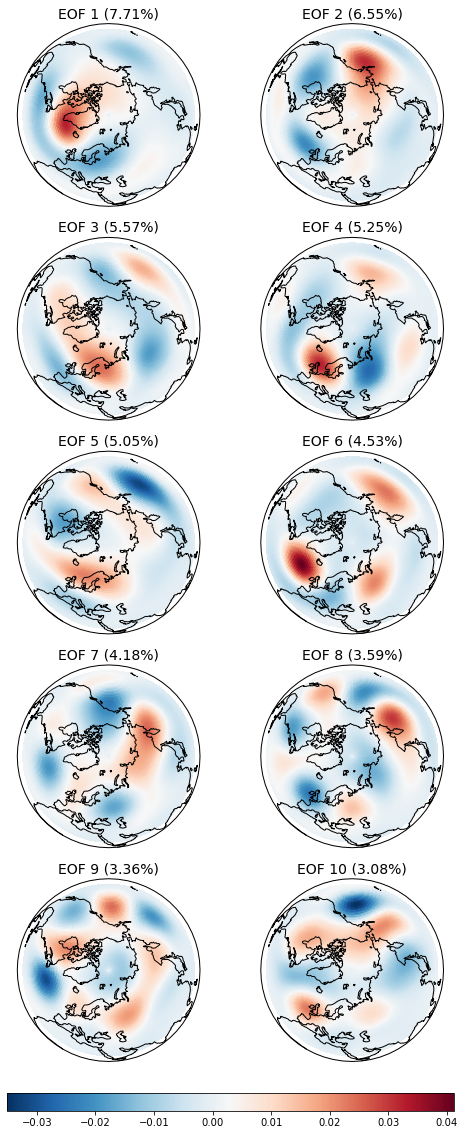

In [664]:
eofs_ds = xr.open_dataset(eofs_output_file)

n_components_to_plot = 10

if n_components_to_plot < np.max(eofs_ds['component']).max().item():
    components = np.arange(n_components_to_plot)
else:
    components = eofs_ds['component'].values

projection = ccrs.Orthographic(central_latitude=90, central_longitude=40)
wrap_lon = True

cmap = plt.cm.RdBu_r

component_vmins = np.empty(n_components_to_plot)
vmin = None
for i, component in enumerate(components):
    component_vmin = eofs_ds['EOFs'].sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components_to_plot)
vmax = None
for i, component in enumerate(components):
    component_vmax = eofs_ds['EOFs'].sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components_to_plot % 2 == 0 else 3
nrows = int(np.ceil(n_components_to_plot / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)

lat = eofs_ds[LAT_NAME]
lon = eofs_ds[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    eof_data = eofs_ds['EOFs'].sel(component=component).values
    expl_var = eofs_ds['explained_variance_ratio'].sel(
        component=component).item()

    if wrap_lon:
        eof_data, eof_lon = add_cyclic_point(eof_data, coord=lon)
    else:
        eof_lon = lon

    lon_grid, lat_grid = np.meshgrid(eof_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.pcolor(lon_grid, lat_grid, eof_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_title('EOF {} ({:.2f}%)'.format(
        component + 1, expl_var * 100), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')

#output_file_basename, _ = os.path.splitext(os.path.basename(eofs_ds.attrs['input_file']))

#output_file = os.path.join(PLOTS_DIR, '.'.join([output_file_basename, 'pca', LAT_WEIGHTS, 'eofs', 'pdf']))

#plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

eofs_ds.close()

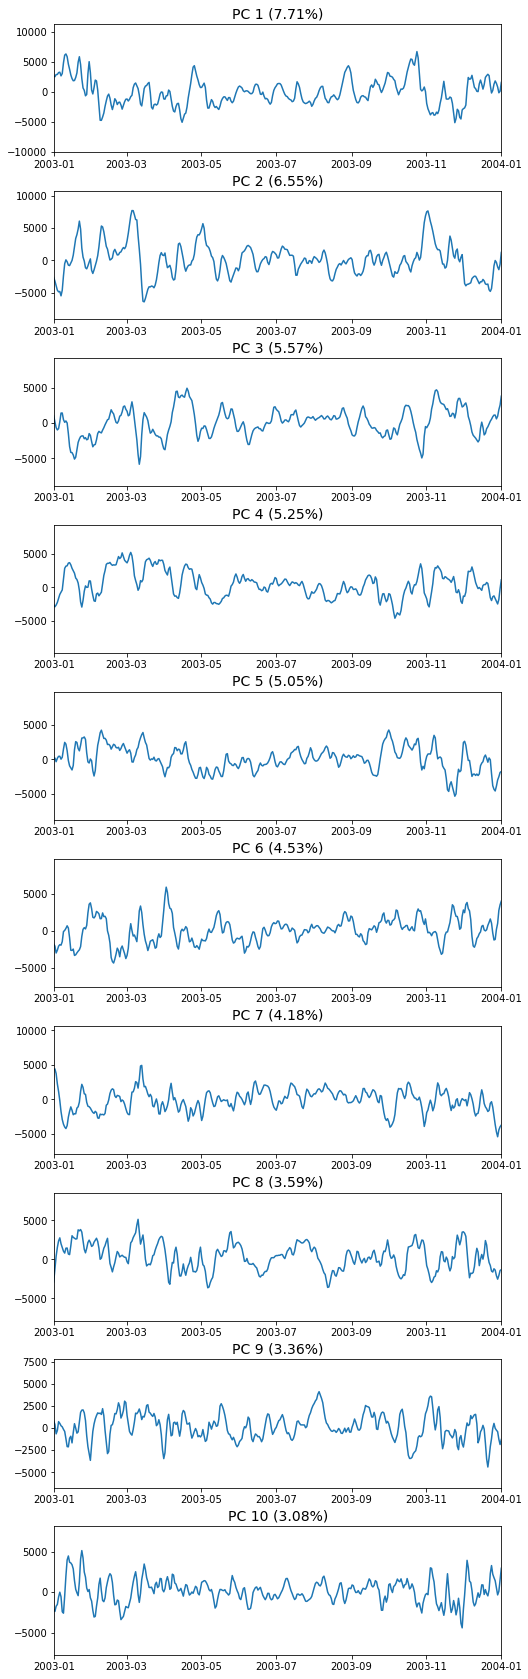

In [668]:
eofs_ds = xr.open_dataset(eofs_output_file)

n_components_to_plot = 10

if n_components_to_plot < np.max(eofs_ds['component']).max().item():
    components = np.arange(n_components_to_plot)
else:
    components = eofs_ds['component'].values

ncols = 1
nrows = int(np.ceil(n_components_to_plot / ncols))

fig = plt.figure(constrained_layout=False, figsize=(8 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,
                       wspace=0.2, hspace=0.3)


for i, component in enumerate(components):
    pc_data = eofs_ds['PCs'].sel(component=component).values
    expl_var = eofs_ds['explained_variance_ratio'].sel(
        component=component).item()

    ax = fig.add_subplot(gs[i, 0])

    ax.plot(eofs_ds[TIME_NAME], pc_data)

    ax.set_xlim(np.datetime64('2003-01-01'), np.datetime64('2004-01-01'))
    ax.set_title('PC {} ({:.2f}%)'.format(
        component + 1, expl_var * 100), fontsize=14)

#output_file_basename, _ = os.path.splitext(os.path.basename(eofs_ds.attrs['input_file']))

#output_file = os.path.join(PLOTS_DIR, '.'.join([output_file_basename, 'pca', LAT_WEIGHTS, 'eofs', 'pdf']))

#plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

eofs_ds.close()

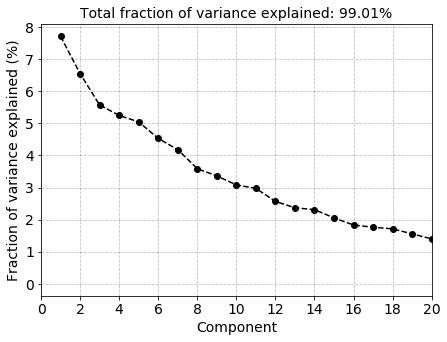

In [150]:
eofs_ds = xr.open_dataset(eofs_output_file)

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(eofs_ds['component'] + 1, 100.0 * eofs_ds['explained_variance_ratio'], 'ko', ls='--')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlim(0, 20)

ax.set_xlabel('Component', fontsize=14)
ax.set_ylabel('Fraction of variance explained (%)', fontsize=14)
ax.set_title(
    'Total fraction of variance explained: {:.2f}%'.format(eofs_ds['explained_variance_ratio'].sum().item() * 100.0),
    fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

output_file_basename, _ = os.path.splitext(os.path.basename(eofs_ds.attrs['input_file']))

output_file = os.path.join(PLOTS_DIR, '.'.join([output_file_basename, 'pca', LAT_WEIGHTS, 'explained_variance', 'pdf']))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

eofs_ds.close()

In the following, as an example of an extreme of interest we investigate the July 2010 Russian heatwave. The
evolution of the 500 hPa geopotential height field and standardized anomalies over this month is plotted below.

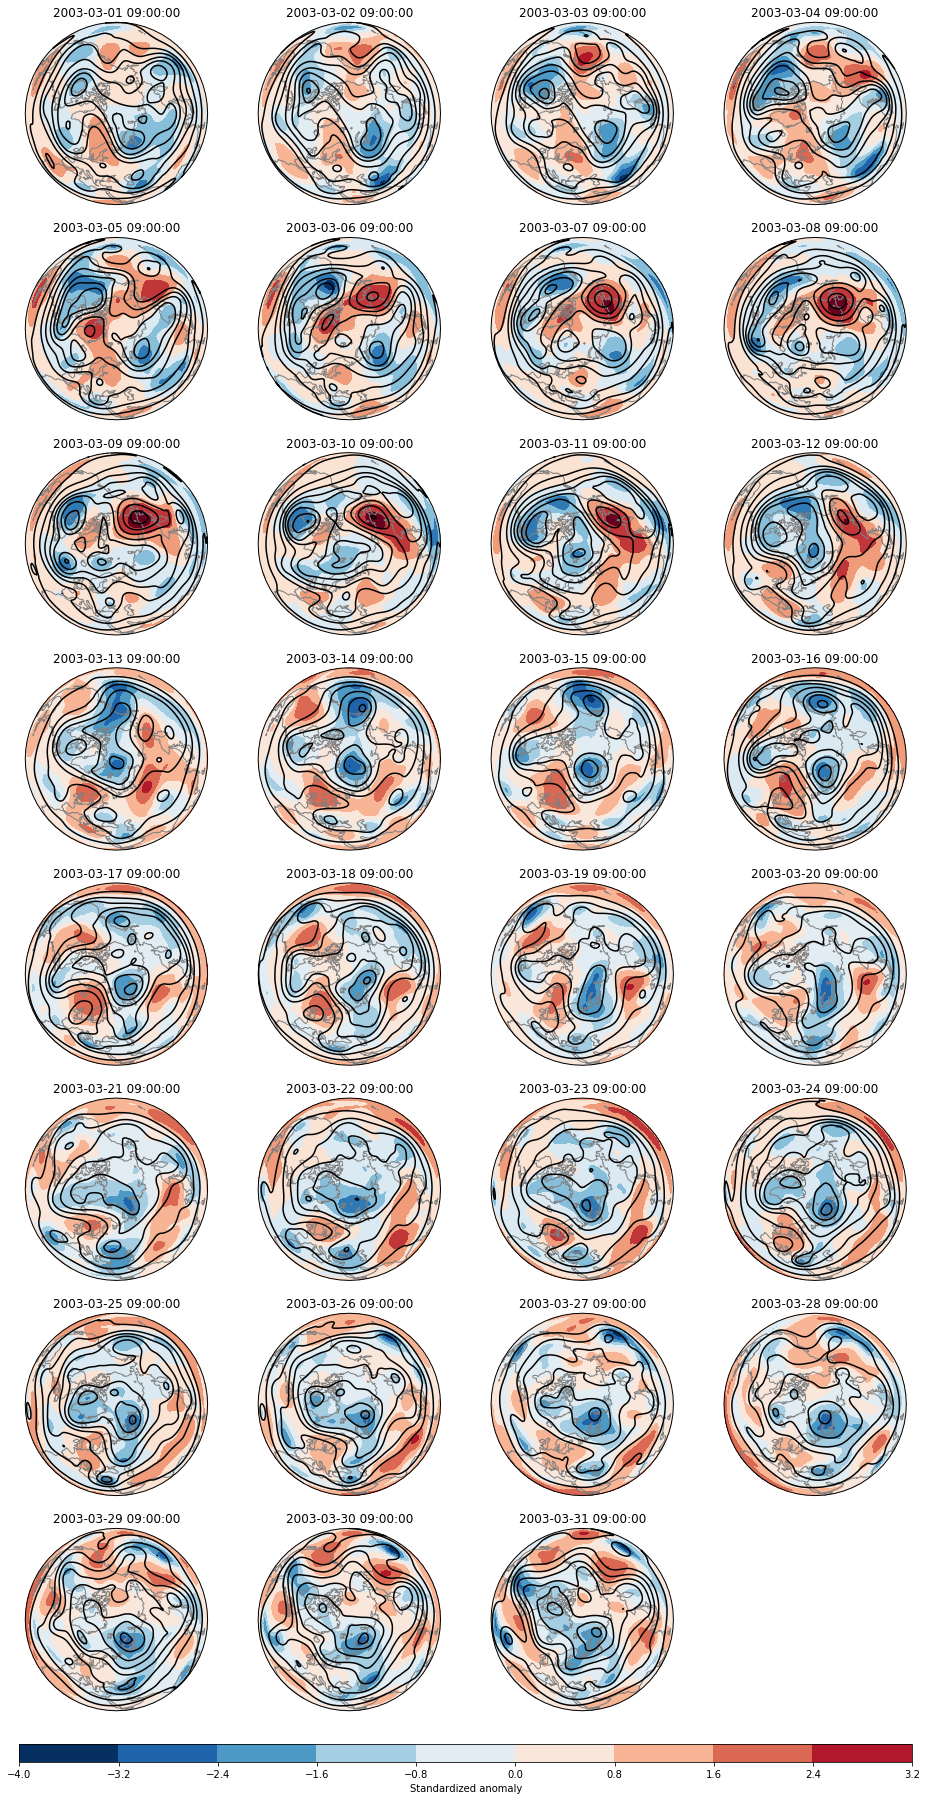

In [670]:
chunks = {LAT_NAME: 'auto', LON_NAME: 'auto', TIME_NAME: 'auto'}
hgt_ds = xr.open_dataset(HGT_INPUT_FILE, chunks=chunks)

hgt_da = hgt_ds[VARIABLE_NAME].squeeze()
#hgt_da = hgt_da.where(
#    (hgt_da[LAT_NAME] >= MIN_LATITUDE) &
#    (hgt_da[LAT_NAME] <= MAX_LATITUDE), drop=True)

anom_ds = xr.open_dataset(hgt_std_anom_output_file, chunks=chunks)

hgt_anom_da = anom_ds[VARIABLE_NAME + '_std_anom'].squeeze()
#hgt_anom_da = hgt_anom_da.where(
#    (hgt_anom_da[LAT_NAME] >= MIN_LATITUDE) &
#    (hgt_anom_da[LAT_NAME] <= MAX_LATITUDE), drop=True)

dates_to_plot = hgt_da[TIME_NAME].where(
    (hgt_da[TIME_NAME] >= np.datetime64('2003-03-01T00:00:00')) &
    (hgt_da[TIME_NAME] <= np.datetime64('2003-03-31T23:59:59')), drop=True)

ncols = 4
nrows = int(np.ceil(np.size(dates_to_plot) / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

cmap = plt.cm.RdBu_r
wrap_lon = True

projection = ccrs.Orthographic(central_latitude=90, central_longitude=40)

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)

lat = hgt_da[LAT_NAME]
lon = hgt_da[LON_NAME]

row_index = 0
col_index = 0
for d in dates_to_plot:
    
    daily_hgt_data = hgt_da.sel({TIME_NAME: d}, drop=True).values
    daily_anom_data = hgt_anom_da.sel({TIME_NAME: d}, drop=True).values

    if wrap_lon:
        daily_hgt_data, daily_hgt_lon = add_cyclic_point(daily_hgt_data, coord=lon)
        daily_anom_data, daily_anom_lon = add_cyclic_point(daily_anom_data, coord=lon)
    else:
        daily_hgt_lon = lon
        
    lon_grid, lat_grid = np.meshgrid(daily_hgt_lon, lat)
    
    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)
    
    ax.coastlines(color='gray')
    ax.set_global()

    cs = ax.contourf(lon_grid, lat_grid, daily_anom_data, transform=ccrs.PlateCarree(),
                    cmap=cmap, vmin=-3.5, vmax=3.5)
    ax.contour(lon_grid, lat_grid, daily_hgt_data, colors='black', transform=ccrs.PlateCarree())
    
    ax.set_title('{}'.format(pd.to_datetime(d.item())))
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')
cb.set_label('Standardized anomaly')

# output_file_basename, _ = os.path.splitext(os.path.basename(eofs_ds.attrs['input_file']))

# output_file = os.path.join(PLOTS_DIR, '.'.join([output_file_basename, 'pca', LAT_WEIGHTS, 'eofs', 'pdf']))

# plt.savefig(output_file, bbox_inches='tight')
plt.savefig('/Users/har1a1/Desktop/jra.55.hgt.500.1958010100_2018123118.1981_2010.anom.2003030109_2003033109.png')
plt.show()

plt.close()

hgt_ds.close()
anom_ds.close()

In [519]:
def to_1d_array(da):
    """Convert DataArray to flat array."""

    flat_data = np.ravel(da.values)

    missing_features = np.isnan(flat_data)

    return flat_data[np.logical_not(missing_features)]


def pattern_correlation(pattern_one, pattern_two):
    """Calculate pattern correlation between patterns."""

    flat_pattern_one = to_1d_array(pattern_one)
    flat_pattern_two = to_1d_array(pattern_two)

    data = np.vstack([flat_pattern_one, flat_pattern_two])

    r = np.corrcoef(data, rowvar=True)

    return r[0, 1]


def sort_states(da1, da2, sample_dim_one='component', sample_dim_two='component', return_sort_order=False):
    """Sort states according to pattern correlation."""

    n_components_one = da1.sizes[sample_dim_one]
    n_components_two = da2.sizes[sample_dim_two]

    sort_order = []

    for i in range(n_components_two):
        correlations = np.empty((n_components_one,))

        for k in range(n_components_one):
            correlations[k] = pattern_correlation(
                da1.sel({sample_dim_one: k}),
                da2.sel({sample_dim_two: i}))

        ordering = np.argsort(-np.abs(correlations))
        for k in range(n_components_one):
            if ordering[k] not in sort_order:
                sort_order.append(ordering[k])
                break

        if np.size(sort_order) == n_components:
            break

    assert len(sort_order) <= n_components_one
    assert np.size(np.unique(sort_order)) == np.size(sort_order)

    if len(sort_order) < n_components_one:
        unassigned = [i for i in range(n_components_one) if i not in sort_order]
        sort_order += unassigned

    assert len(sort_order) == n_components_one
    assert np.size(np.unique(sort_order)) == np.size(sort_order)

    if return_sort_order:
        return sort_order

    sorted_da = xr.zeros_like(da1)
    for i in range(n_components):
        sorted_da = xr.where(sorted_da[sample_dim_one] == i,
                             da1.sel({sample_dim_one: sort_order[i]}), sorted_da)

    for a in da1.attrs:
        sorted_da.attrs[a] = da1.attrs[a]

    return sorted_da

In [524]:
def apply_ordering(da, sort_order, sample_dim='component'):
    """Apply new ordering of sample dimension."""
    
    n_components = da.sizes[sample_dim]

    sorted_da = xr.zeros_like(da)
    for i in range(n_components):
        sorted_da = xr.where(sorted_da[sample_dim] == i,
                             da.sel({sample_dim: sort_order[i]}), sorted_da)

    for a in da.attrs:
        sorted_da.attrs[a] = da.attrs[a]
        
    return sorted_da

## k-means clustering of 500 hPa geopotential height anomalies

We first run k-means on the PCs of the daily height anomalies, and reconstruct the corresponding
cluster centroids. For comparison, we also run a k-means clustering on the initial anomaly fields.
See bin/run_jra55_kmeans.py and bin/run_jra55_pca_kmeans.py:

In [13]:
with open(os.path.join(BIN_DIR, 'run_jra55_kmeans.py')) as ifs:
    for line in ifs:
        print(line.strip('\n'))

"""
Run k-means on JRA-55 500 hPa height anomalies.
"""

# License: MIT

from __future__ import absolute_import, division, print_function

import argparse
import time

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_random_state
import xarray as xr

from convex_dim_red import gap_statistic

LAT_NAME = 'g0_lat_2'
LON_NAME = 'g0_lon_3'
TIME_NAME = 'initial_time0_hours'
ANOMALY_NAME = 'HGT_GDS0_ISBL_anom'
STD_ANOMALY_NAME = 'HGT_GDS0_ISBL_std_anom'

# First and last years to retain for analysis
START_YEAR = 1958
END_YEAR = 2018

# Zonal extents of analysis region
MIN_LATITUDE = 20.0
MAX_LATITUDE = 90.0


def parse_cmd_line_args():
    """Parse command line arguments."""

    parser = argparse.ArgumentParser(
        description='Run k-means on JRA-55 500 hPa height anomalies')

    parser.add_argument('input_file',
                        help='input file containing height anomalies')
    parser.add_argum

In [14]:
with open(os.path.join(BIN_DIR, 'run_jra55_pca_kmeans.py')) as ifs:
    for line in ifs:
        print(line.strip('\n'))

"""
Run k-means on PCs of JRA-55 500 hPa height anomalies.
"""

# License: MIT

from __future__ import absolute_import, division, print_function

import argparse
import time

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_random_state
import xarray as xr

from convex_dim_red import gap_statistic


TIME_NAME = 'initial_time0_hours'

# First and last years to retain for analysis
START_YEAR = 1958
END_YEAR = 2018


def parse_cmd_line_args():
    """Parse command line arguments."""

    parser = argparse.ArgumentParser(
        description='Run k-means on PCs of JRA-55 500 hPa height anomalies')

    parser.add_argument('input_file',
                        help='input file containing height anomalies')
    parser.add_argument('output_file',
                        help='name of output file')
    parser.add_argument('--n-components', dest='n_components', type=int,
                        default=1, help='

We first compare the centroids obtained via the two clustering experiments.

In [15]:
def get_kmeans_output_filename(input_file, lat_weights, n_components, n_init, gap_reference='pca'):
    """Get k-means output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    suffix = 'kmeans.{}.k{:d}.n_init{:d}.{}_gap'.format(lat_weights, n_components, n_init, gap_reference)
        
    return '.'.join([basename, suffix]) + ext

In [114]:
def get_pca_kmeans_output_filename(input_file, n_components, n_init, gap_reference='pca', standardized=False):
    """Get k-means output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    if standardized:
        suffix = 'kmeans.k{:d}.standardized.n_init{:d}.{}_gap'.format(n_components, n_init, gap_reference)
    else:
        suffix = 'kmeans.k{:d}.n_init{:d}.{}_gap'.format(n_components, n_init, gap_reference)
        
    return '.'.join([basename, suffix]) + ext

In [541]:
def get_pca_kmeans_centroids(kmeans_filename, eofs_input_file, standardized=False, time_name=TIME_NAME, sort_by_eofs=True):
    """Reconstruct physical space cluster centroids from PCs."""
    
    kmeans_ds = xr.open_dataset(kmeans_filename)

    eofs_ds = xr.open_dataset(eofs_input_file)
    
    dictionary = kmeans_ds['dictionary']
    kmeans_centroids_da = dictionary.dot(eofs_ds['EOFs'])

    if sort_by_eofs:
        kmeans_centroids_da = sort_states(kmeans_centroids_da, eofs_ds['EOFs'], sample_dim_one='cluster', sample_dim_two='component')
    
    kmeans_ds.close()
    eofs_ds.close()

    return kmeans_centroids_da

In [545]:
def get_pca_kmeans_centroids_ordering(kmeans_filename, eofs_input_file, standardized=False, time_name=TIME_NAME):
    """Calculate fixed ordering for clusters."""
    
    kmeans_ds = xr.open_dataset(kmeans_filename)

    eofs_ds = xr.open_dataset(eofs_input_file)
    
    dictionary = kmeans_ds['dictionary']
    kmeans_centroids_da = dictionary.dot(eofs_ds['EOFs'])

    ordering= sort_states(kmeans_centroids_da, eofs_ds['EOFs'], sample_dim_one='cluster', sample_dim_two='component',
                          return_sort_order=True)
    
    kmeans_ds.close()
    eofs_ds.close()

    return ordering

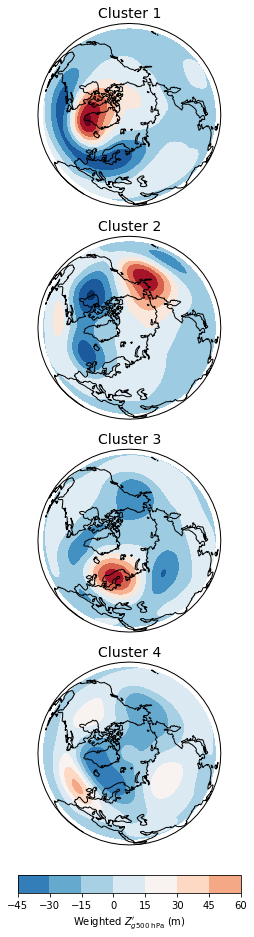

In [357]:
n_components = 4
n_eofs = 167
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init)

kmeans_centroids_da = get_kmeans_pca_centroids(kmeans_output_file, eofs_output_file)

components = kmeans_centroids_da['cluster'].values

projection = ccrs.Orthographic(central_latitude=90, central_longitude=40)
wrap_lon = True

cmap = plt.cm.RdBu_r

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = kmeans_centroids_da.sel(cluster=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = kmeans_centroids_da.sel(cluster=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 1 # 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)

lat = kmeans_centroids_da[LAT_NAME]
lon = kmeans_centroids_da[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    centroid_data = kmeans_centroids_da.sel(cluster=component).values

    if wrap_lon:
        centroid_data, centroid_lon = add_cyclic_point(centroid_data, coord=lon)
    else:
        centroid_lon = lon

    lon_grid, lat_grid = np.meshgrid(centroid_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, centroid_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_title('Cluster {}'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')
cb.set_label('Weighted $Z_{g500\;\mathrm{hPa}}^\prime$ (m)')

output_filename = (os.path.splitext(os.path.basename(kmeans_output_file))[0] + '.centroids.pdf')
output_file = os.path.join(PLOTS_DIR, output_filename)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

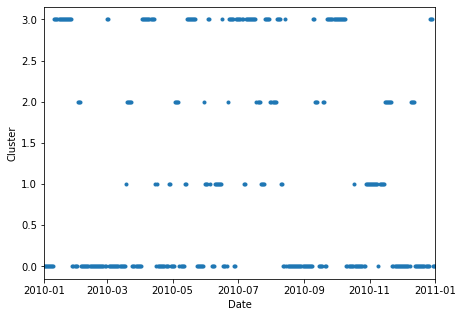

In [216]:
n_components = 4
n_eofs = 167
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init)

kmeans_ds = xr.open_dataset(kmeans_output_file)

n_samples = kmeans_ds.sizes[TIME_NAME]

cluster_labels = np.zeros((n_samples,))
for i in range(n_components):
    mask = kmeans_ds['weights'].sel(cluster=i).values != 0
    cluster_labels[mask] = i

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(kmeans_ds[TIME_NAME], cluster_labels, '.')

ax.set_xlim(np.datetime64('2010-01-01'), np.datetime64('2011-01-01'))
ax.set_xlabel('Date')
ax.set_ylabel('Cluster')

plt.show()
plt.close()

kmeans_ds.close()

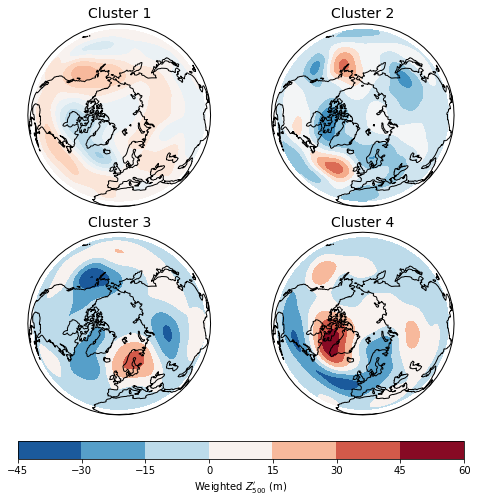

In [199]:
n_components = 4
n_eofs = 167
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init, standardized=True)

kmeans_centroids_da = get_kmeans_pca_centroids(kmeans_output_file, eofs_output_file, standardized=True)

components = kmeans_centroids_da['cluster'].values

projection = ccrs.Orthographic(central_latitude=90, central_longitude=0)
wrap_lon = True

cmap = plt.cm.RdBu_r

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = kmeans_centroids_da.sel(cluster=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = kmeans_centroids_da.sel(cluster=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)

lat = kmeans_centroids_da[LAT_NAME]
lon = kmeans_centroids_da[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    centroid_data = kmeans_centroids_da.sel(cluster=component).values

    if wrap_lon:
        centroid_data, centroid_lon = add_cyclic_point(centroid_data, coord=lon)
    else:
        centroid_lon = lon

    lon_grid, lat_grid = np.meshgrid(centroid_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, centroid_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_title('Cluster {}'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')
cb.set_label('Weighted $Z_{500}^\prime$ (m)')

plt.show()

plt.close()

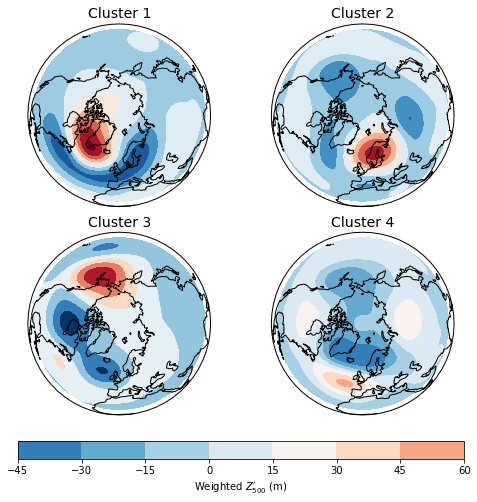

In [144]:
n_components = 4
n_eofs = 167
n_init = 100
reference = 'pca'
lat_weights = 'scos'

kmeans_output_file = get_kmeans_output_filename(anom_input_file, lat_weights, n_components, n_init)

kmeans_ds = xr.open_dataset(kmeans_output_file)

kmeans_centroids_da = kmeans_ds['dictionary']

components = kmeans_centroids_da['component'].values

projection = ccrs.Orthographic(central_latitude=90, central_longitude=0)
wrap_lon = True

cmap = plt.cm.RdBu_r

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = kmeans_centroids_da.sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = kmeans_centroids_da.sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)

lat = kmeans_centroids_da[LAT_NAME]
lon = kmeans_centroids_da[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    centroid_data = kmeans_centroids_da.sel(component=component).values

    if wrap_lon:
        centroid_data, centroid_lon = add_cyclic_point(centroid_data, coord=lon)
    else:
        centroid_lon = lon

    lon_grid, lat_grid = np.meshgrid(centroid_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, centroid_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_title('Cluster {}'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')
cb.set_label('Weighted $Z_{500}^\prime$ (m)')

plt.show()

plt.close()

kmeans_ds.close()

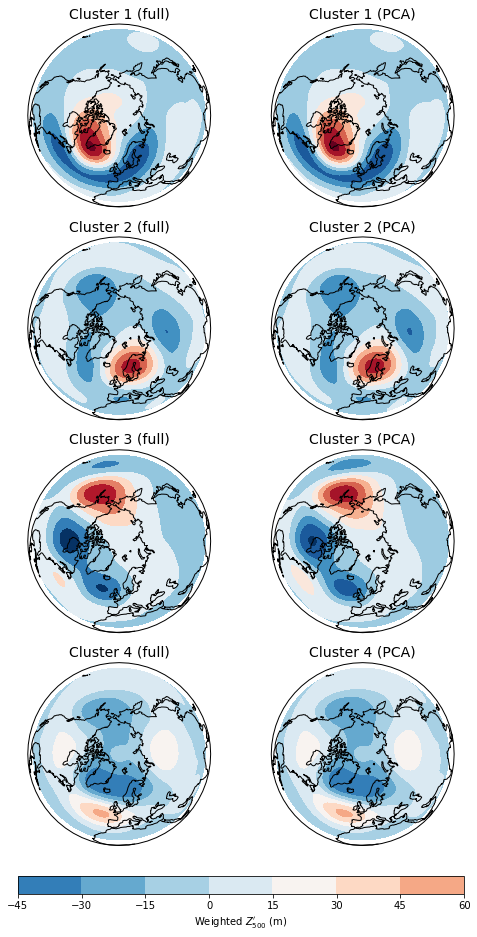

In [327]:
n_components = 4
n_eofs = 167
n_init = 100
reference = 'pca'
lat_weights = 'scos'

pca_kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init)
pca_kmeans_centroids_da = get_kmeans_pca_centroids(pca_kmeans_output_file, eofs_output_file)

kmeans_output_file = get_kmeans_output_filename(anom_input_file, lat_weights, n_components, n_init)

kmeans_ds = xr.open_dataset(kmeans_output_file)
kmeans_centroids_da = kmeans_ds['dictionary']

pca_kmeans_centroids_da = sort_states(pca_kmeans_centroids_da, kmeans_centroids_da, sample_dim_one='cluster', sample_dim_two='component')

components = kmeans_centroids_da['component'].values

projection = ccrs.Orthographic(central_latitude=90, central_longitude=0)
wrap_lon = True

cmap = plt.cm.RdBu_r

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = kmeans_centroids_da.sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

for i, component in enumerate(components):
    component_vmin = pca_kmeans_centroids_da.sel(cluster=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = kmeans_centroids_da.sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

for i, component in enumerate(components):
    component_vmax = pca_kmeans_centroids_da.sel(cluster=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2
nrows = n_components
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)

lat = kmeans_centroids_da[LAT_NAME]
lon = kmeans_centroids_da[LON_NAME]

for i, component in enumerate(components):
    pca_centroid_data = pca_kmeans_centroids_da.sel(cluster=component).values
    centroid_data = kmeans_centroids_da.sel(component=component).values

    if wrap_lon:
        centroid_data, centroid_lon = add_cyclic_point(centroid_data, coord=lon)
        pca_centroid_data, _ = add_cyclic_point(pca_centroid_data, coord=lon)
    else:
        centroid_lon = lon

    lon_grid, lat_grid = np.meshgrid(centroid_lon, lat)

    ax = fig.add_subplot(gs[i, 0], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, centroid_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_title('Cluster {} (full)'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    ax = fig.add_subplot(gs[i, 1], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, pca_centroid_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_title('Cluster {} (PCA)'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')
cb.set_label('Weighted $Z_{500}^\prime$ (m)')

plt.show()

plt.close()

kmeans_ds.close()

In [22]:
max_n_components = 20
n_init = 100
reference = 'pca'

pca_kmeans_k = []
pca_kmeans_gap = []
pca_kmeans_gap_sk = []

for i in range(1, max_n_components + 1):

    output_file = get_pca_kmeans_output_filename(eofs_output_file, i, n_init)
    
    with xr.open_dataset(output_file) as ds:
        
        pca_kmeans_k.append(ds.sizes['cluster'])
        pca_kmeans_gap.append(float(ds.attrs['gap_statistic']))
        pca_kmeans_gap_sk.append(float(ds.attrs['gap_sk']))
        
pca_kmeans_k = np.array(pca_kmeans_k)
pca_kmeans_gap = np.array(pca_kmeans_gap)
pca_kmeans_gap_sk = np.array(pca_kmeans_gap_sk)

gap_cluster = None
gap_criterion = None
for i in range(max_n_components - 1):
    if pca_kmeans_gap[i] >= pca_kmeans_gap[i + 1] - pca_kmeans_gap_sk[i + 1]:
        gap_criterion = pca_kmeans_gap[i]
        gap_cluster = i
        break
        
if gap_criterion is None:
    print('No k satisfying gap criterion')
else:
    print('Cluster selected by gap criterion = ', gap_cluster)

gap_output_filename = (os.path.splitext(os.path.basename(eofs_output_file))[0] +
                       'kmeans.n_init{:d}.{}_gap.gap.csv'.format(n_init, reference))
gap_output_file = os.path.join(CSV_DIR, gap_output_filename)

gap_data = np.zeros((pca_kmeans_k.shape[0], 3))
gap_data[:, 0] = pca_kmeans_k
gap_data[:, 1] = pca_kmeans_gap
gap_data[:, 2] = pca_kmeans_gap_sk

header = 'n_components,gap_statistic,gap_sk'
fmt = '%d,%16.8e,%16.8e'

np.savetxt(gap_output_file, gap_data, header=header, fmt=fmt)

Cluster selected by gap criterion =  0


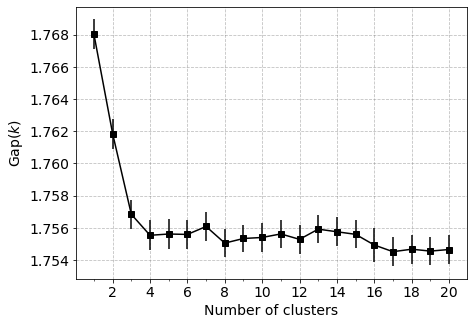

In [23]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.errorbar(pca_kmeans_k, pca_kmeans_gap, yerr=pca_kmeans_gap_sk, fmt='k', marker='s')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('$\mathrm{Gap}(k)$', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

plt.show()

plt.close()

In [140]:
max_n_components = 20
n_init = 100
reference = 'pca'

pca_kmeans_k = []
pca_kmeans_cost = []
pca_kmeans_rmse = []

for i in range(1, max_n_components + 1):

    output_file = get_pca_kmeans_output_filename(eofs_output_file, i, n_init)
    
    with xr.open_dataset(output_file) as ds:
        
        pca_kmeans_k.append(ds.sizes['cluster'])
        pca_kmeans_cost.append(float(ds.attrs['cost']))
        pca_kmeans_rmse.append(float(ds.attrs['rmse']))
        
pca_kmeans_k = np.array(pca_kmeans_k)
pca_kmeans_cost = np.array(pca_kmeans_cost)
pca_kmeans_rmse = np.array(pca_kmeans_rmse)

cost_output_file = (os.path.splitext(os.path.basename(eofs_output_file))[0] +
                       'kmeans.n_init{:d}.{}_gap.cost.csv'.format(n_init, reference))
cost_output_file = os.path.join(CSV_DIR, cost_output_file)

cost_data = np.zeros((pca_kmeans_k.shape[0], 3))
cost_data[:, 0] = pca_kmeans_k
cost_data[:, 1] = pca_kmeans_cost
cost_data[:, 2] = pca_kmeans_rmse

header = 'n_components,cost,rmse'
fmt = '%d,%16.8e,%16.8e'

np.savetxt(cost_output_file, cost_data, header=header, fmt=fmt)

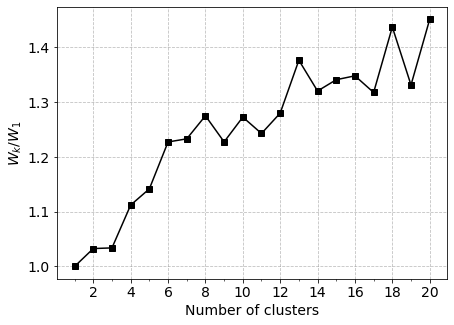

In [326]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(pca_kmeans_k, (pca_kmeans_cost / pca_kmeans_cost[0]) ** (-0.5 * 30) - np.hstack([np.array([0]), (pca_kmeans_cost[:-1] / pca_kmeans_cost[0]) ** (-0.5 * 30)]), 'k-', marker='s')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('$W_k / W_1$', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

plt.show()

plt.close()

In [124]:
max_n_components = 20
n_init = 100
reference = 'pca'

pca_kmeans_std_k = []
pca_kmeans_std_gap = []
pca_kmeans_std_gap_sk = []

for i in range(1, max_n_components + 1):

    output_file = get_pca_kmeans_output_filename(eofs_output_file, i, n_init, standardized=True)
    
    with xr.open_dataset(output_file) as ds:
        
        pca_kmeans_std_k.append(ds.sizes['cluster'])
        pca_kmeans_std_gap.append(float(ds.attrs['gap_statistic']))
        pca_kmeans_std_gap_sk.append(float(ds.attrs['gap_sk']))
        
pca_kmeans_std_k = np.array(pca_kmeans_std_k)
pca_kmeans_std_gap = np.array(pca_kmeans_std_gap)
pca_kmeans_std_gap_sk = np.array(pca_kmeans_std_gap_sk)

gap_cluster = None
gap_criterion = None
for i in range(max_n_components - 1):
    if pca_kmeans_std_gap[i] >= pca_kmeans_std_gap[i + 1] - pca_kmeans_std_gap_sk[i + 1]:
        gap_criterion = pca_kmeans_std_gap[i]
        gap_cluster = i
        break
        
if gap_criterion is None:
    print('No k satisfying gap criterion')
else:
    print('Cluster selected by gap criterion = ', gap_cluster)

gap_output_filename = (os.path.splitext(os.path.basename(eofs_output_file))[0] +
                       'kmeans.standardized.n_init{:d}.{}_gap.gap.csv'.format(n_init, reference))
gap_output_file = os.path.join(CSV_DIR, gap_output_filename)

gap_data = np.zeros((pca_kmeans_std_k.shape[0], 3))
gap_data[:, 0] = pca_kmeans_std_k
gap_data[:, 1] = pca_kmeans_std_gap
gap_data[:, 2] = pca_kmeans_std_gap_sk

header = 'n_components,gap_statistic,gap_sk'
fmt = '%d,%16.8e,%16.8e'

np.savetxt(gap_output_file, gap_data, header=header, fmt=fmt)

Cluster selected by gap criterion =  0


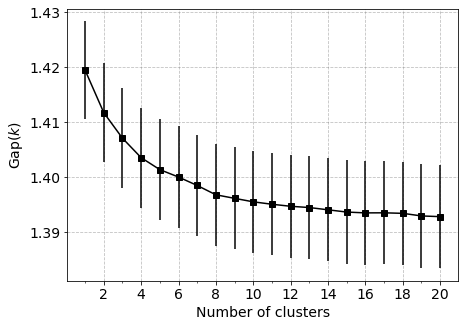

In [125]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.errorbar(pca_kmeans_std_k, pca_kmeans_std_gap, yerr=pca_kmeans_std_gap_sk, fmt='k', marker='s')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('$\mathrm{Gap}(k)$', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

plt.show()

plt.close()

In [ ]:
max_n_components = 20
n_init = 100
reference = 'pca'
lat_weights = 'scos'

kmeans_k = []
kmeans_gap = []
kmeans_gap_sk = []

for i in range(1, max_n_components + 1):

    output_file = get_kmeans_output_filename(anom_input_file, lat_weights, i, n_init)
    
    with xr.open_dataset(output_file) as ds:
        
        kmeans_k.append(ds.sizes['component'])
        kmeans_gap.append(float(ds.attrs['gap_statistic']))
        kmeans_gap_sk.append(float(ds.attrs['gap_sk']))
        
kmeans_k = np.array(kmeans_k)
kmeans_gap = np.array(kmeans_gap)
kmeans_gap_sk = np.array(kmeans_gap_sk)

gap_cluster = None
gap_criterion = None
for i in range(max_n_components - 1):
    if kmeans_gap[i] >= kmeans_gap[i + 1] - kmeans_gap_sk[i + 1]:
        gap_criterion = kmeans_gap[i]
        gap_cluster = i
        
if gap_criterion is None:
    print('No k satisfying gap criterion')
else:
    print('Cluster selected by gap criterion = ', gap_cluster)

gap_output_filename = (os.path.splitext(os.path.basename(anom_input_file))[0] +
                       'kmeans.{}.n_init{:d}.{}_gap.gap.csv'.format(lat_weights, n_init, reference))
gap_output_file = os.path.join(CSV_DIR, gap_output_filename)

gap_data = np.zeros((kmeans_k.shape[0], 3))
gap_data[:, 0] = kmeans_k
gap_data[:, 1] = kmeans_gap
gap_data[:, 2] = kmeans_gap_sk

header = 'n_components,gap_statistic,gap_sk'
fmt = '%d,%16.8e,%16.8e'

np.savetxt(gap_output_file, gap_data, header=header, fmt=fmt)

In [25]:
def weight_and_flatten_data(da, weights=None, sample_dim=TIME_NAME):
    """Apply weighting to data and convert to 2D array."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    if weights is not None:
        weighted_da = (weights * da).transpose(*da.dims)
    else:
        weighted_da = da

    if weighted_da.get_axis_num(sample_dim) != 0:
        weighted_da = weighted_da.transpose(*([sample_dim] + feature_dims))

    n_samples = weighted_da.sizes[sample_dim]
    n_features = np.product(original_shape)

    flat_data = weighted_da.data.reshape(n_samples, n_features)

    return flat_data


def run_mds(arrays, n_components=2, metric=True,
            n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None,
            random_state=None, sample_dim=TIME_NAME):
    """Run MDS on given data."""

    variable_names = [v for v in arrays]
    n_variables = len(variable_names)

    # Convert input arrays to plain 2D arrays
    flat_arrays = [weight_and_flatten_data(arrays[variable_names[i]], sample_dim=sample_dim)
                   for i in range(n_variables)]
    
    n_samples = [a.shape[0] for a in flat_arrays]
    total_input_rows = np.sum(n_samples)

    n_features = None
    for a in flat_arrays:
        if n_features is None:
            n_features = a.shape[1]
        else:
            if a.shape[1] != n_features:
                raise ValueError('All arrays do not have same number of feature dimensions')

    flat_data = np.vstack(flat_arrays)

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]
    
    # Add the origin in initial space for reference
    valid_data = np.vstack([valid_data, np.zeros(valid_data.shape[1])])

    mds = MDS(n_components=n_components, metric=metric, n_init=n_init,
              max_iter=max_iter, verbose=verbose, eps=eps, n_jobs=n_jobs,
              random_state=random_state, dissimilarity='euclidean').fit(valid_data)
    
    results = {v: None for v in arrays}
    
    row_start = 0
    for i in range(n_variables):
        
        v = variable_names[i]
        n_rows = n_samples[i]

        embedding_da = xr.DataArray(
            mds.embedding_[row_start:row_start + n_rows],
            coords={sample_dim: arrays[v][sample_dim], 'mds_coord': np.arange(n_components)},
            dims=[sample_dim, 'mds_coord'])
        
        origin_da = xr.DataArray(
            mds.embedding_[-1], coords={'mds_coord': np.arange(n_components)},
            dims=['mds_coord'])
        
        results[v] = xr.Dataset({'embedding': embedding_da, 'origin': origin_da})
        results[v].attrs['stress'] = '{:16.8e}'.format(mds.stress_)
        
        row_start += n_rows
        
    return results

In [97]:
n_components = 4
n_init = 100
reference = 'pca'

pca_kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init)
pca_kmeans_centroids_da = get_kmeans_pca_centroids(pca_kmeans_output_file, eofs_output_file)

kmeans_ds = xr.open_dataset(pca_kmeans_output_file)
eofs_ds = xr.open_dataset(eofs_output_file)

pca_kmeans_centroids_da = kmeans_ds['dictionary']
pca_kmeans_labels_da = kmeans_ds['weights']

pca_kmeans_centroids_da = pca_kmeans_centroids_da.rename({'cluster': TIME_NAME})

mds_2d_results = run_mds({'PCs': eofs_ds['PCs'].isel({TIME_NAME: slice(0, None, 10)}), 'centroids': pca_kmeans_centroids_da},
                         n_components=2, random_state=0, sample_dim=TIME_NAME)

eofs_ds.close()
kmeans_ds.close()

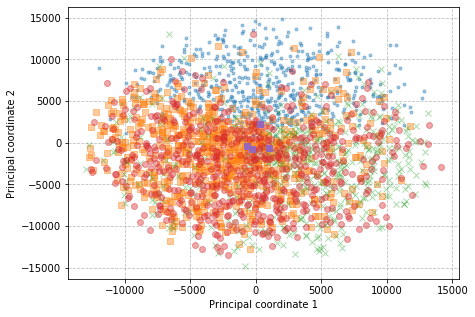

In [98]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

pcs_x_coords = mds_2d_results['PCs']['embedding'].sel(mds_coord=0).values
pcs_y_coords = mds_2d_results['PCs']['embedding'].sel(mds_coord=1).values

markers = itertools.cycle(('.', 's', 'x', 'o', '+', 'd'))

n_components = pca_kmeans_labels_da.sizes['cluster']

#cs = ax.hist2d(pcs_x_coords, pcs_y_coords, 10, density=False)[-1]
for i in range(n_components):
    mask = pca_kmeans_labels_da.isel({TIME_NAME: slice(0, None, 10)}).values[:, i] != 0

    marker = next(markers)
    ax.plot(pcs_x_coords[mask], pcs_y_coords[mask], marker=marker, ls='none', alpha=0.4)

centroids_x_coords = mds_2d_results['centroids']['embedding'].sel(mds_coord=0)
centroids_y_coords = mds_2d_results['centroids']['embedding'].sel(mds_coord=1)

ax.plot(centroids_x_coords, centroids_y_coords, 's', ls='none')
#cb = plt.colorbar(cs)
ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Principal coordinate 1')
ax.set_ylabel('Principal coordinate 2')

plt.show()

plt.close()

In [100]:
n_components = 4
n_init = 100
reference = 'pca'

pca_kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init)

kmeans_ds = xr.open_dataset(pca_kmeans_output_file)
eofs_ds = xr.open_dataset(eofs_output_file)

pca_kmeans_centroids_da = kmeans_ds['dictionary']
pca_kmeans_labels_da = kmeans_ds['weights']

pca_kmeans_centroids_da = pca_kmeans_centroids_da.rename({'cluster': TIME_NAME})

mds_3d_results = run_mds({'PCs': eofs_ds['PCs'].isel({TIME_NAME: slice(0, None, 10)}), 'centroids': pca_kmeans_centroids_da},
                         n_components=3, random_state=0, sample_dim=TIME_NAME)

eofs_ds.close()
kmeans_ds.close()

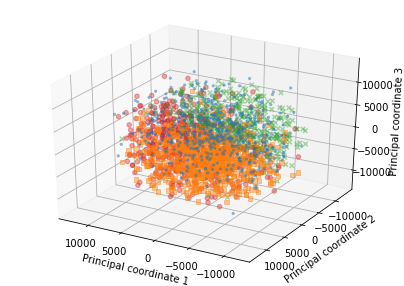

In [111]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

pcs_x_coords = mds_3d_results['PCs']['embedding'].sel(mds_coord=0)
pcs_y_coords = mds_3d_results['PCs']['embedding'].sel(mds_coord=1)
pcs_z_coords = mds_3d_results['PCs']['embedding'].sel(mds_coord=2)

markers = itertools.cycle(('.', 's', 'x', 'o', '+', 'd'))

n_components = pca_kmeans_labels_da.sizes['cluster']

for i in range(n_components):
    mask = pca_kmeans_labels_da.isel({TIME_NAME: slice(0, None, 10)}).values[:, i] != 0

    marker = next(markers)

    ax.scatter(pcs_x_coords[mask], pcs_y_coords[mask], pcs_z_coords[mask], marker=marker, alpha=0.4)

centroids_x_coords = mds_3d_results['centroids']['embedding'].sel(mds_coord=0)
centroids_y_coords = mds_3d_results['centroids']['embedding'].sel(mds_coord=1)
centroids_z_coords = mds_3d_results['centroids']['embedding'].sel(mds_coord=2)

ax.scatter(centroids_x_coords, centroids_y_coords, centroids_z_coords, marker='s')

ax.set_xlabel('Principal coordinate 1')
ax.set_ylabel('Principal coordinate 2')
ax.set_zlabel('Principal coordinate 3')

ax.view_init(elev=30, azim=120)

plt.show()

plt.close()

## Convex coding of 500 hPa geopotential height anomalies

We can perform a similar analysis using the regularized convex coding.
See bin/run_jra55_pca_gpnh.py:

In [155]:
with open(os.path.join(BIN_DIR, 'run_jra55_pca_gpnh.py')) as ifs:
    for line in ifs:
        print(line.strip('\n'))

"""
Run GPNH-regularized convex coding on PCs of JRA-55 500 hPa height anomalies.
"""

# License: MIT

from __future__ import absolute_import, division, print_function

import argparse
from copy import deepcopy
import time

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_random_state
import xarray as xr

from convex_dim_red import GPNHConvexCoding


TIME_NAME = 'initial_time0_hours'

# First and last years to retain for analysis
START_YEAR = 1870
END_YEAR = 2018

# Number of random restarts to use
INIT = 'random'
N_INIT = 100

# Stopping criteria
MAX_ITERATIONS = 10000
TOLERANCE = 1e-6


def parse_cmd_line_args():
    """Parse command line arguments."""

    parser = argparse.ArgumentParser(
        description='Run GPNH-regularized convex coding on PCs of JRA-55 500 hPa height anomalies'
    )

    parser.add_argument('input_file',
                        help='input file containing SST anomalies')
    parser.add_argument('output_file'

In [156]:
def get_pca_gpnh_output_filename(input_file, n_components, lambda_W, n_init):
    """Get GPNH-regularized convex coding output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    suffix = 'gpnh.k{:d}.lambda_W{:5.3e}.n_init{:d}'.format(n_components, lambda_W, n_init)
        
    return '.'.join([basename, suffix]) + ext

In [527]:
def get_pca_gpnh_dictionary(gpnh_filename, eofs_input_file,time_name=TIME_NAME, sort_by_eofs=True):
    """Reconstruct physical space dictionary vectors from PCs."""
    
    gpnh_ds = xr.open_dataset(gpnh_filename)

    eofs_ds = xr.open_dataset(eofs_input_file)
    
    dictionary = gpnh_ds['dictionary']

    dictionary_da = dictionary.dot(eofs_ds['EOFs'])
    
    if sort_by_eofs:
        dictionary_da = sort_states(dictionary_da, eofs_ds['EOFs'], sample_dim_one='state', sample_dim_two='component')
    
    gpnh_ds.close()
    eofs_ds.close()

    return dictionary_da

In [529]:
def get_pca_gpnh_dictionary_ordering(gpnh_filename, eofs_input_file, time_name=TIME_NAME):
    """Calculate fixed ordering of dictionary vectors."""
    
    gpnh_ds = xr.open_dataset(gpnh_filename)

    eofs_ds = xr.open_dataset(eofs_input_file)
    
    dictionary = gpnh_ds['dictionary']

    dictionary_da = dictionary.dot(eofs_ds['EOFs'])
    
    ordering = sort_states(dictionary_da, eofs_ds['EOFs'], sample_dim_one='state', sample_dim_two='component', return_sort_order=True)
    
    gpnh_ds.close()
    eofs_ds.close()

    return ordering

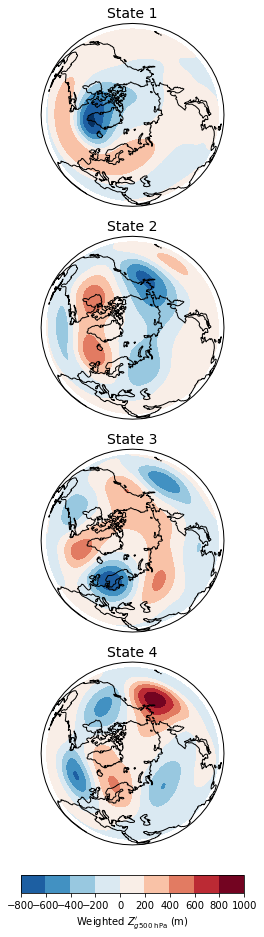

In [359]:
n_components = 4
lambda_W = 0
n_eofs = 167
n_init = 100

gpnh_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, lambda_W, n_init)

gpnh_dictionary_da = get_gpnh_pca_dictionary(gpnh_output_file, eofs_output_file)

components = gpnh_dictionary_da['state'].values

projection = ccrs.Orthographic(central_latitude=90, central_longitude=40)
wrap_lon = True

cmap = plt.cm.RdBu_r

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = gpnh_dictionary_da.sel(state=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = gpnh_dictionary_da.sel(state=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 1 #2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)

lat = gpnh_dictionary_da[LAT_NAME]
lon = gpnh_dictionary_da[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    centroid_data = gpnh_dictionary_da.sel(state=component).values

    if wrap_lon:
        centroid_data, centroid_lon = add_cyclic_point(centroid_data, coord=lon)
    else:
        centroid_lon = lon

    lon_grid, lat_grid = np.meshgrid(centroid_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, centroid_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_title('State {}'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')
cb.set_label('Weighted $Z_{g500\;\mathrm{hPa}}^\prime$ (m)')

output_filename = (os.path.splitext(os.path.basename(gpnh_output_file))[0] + '.dictionary.pdf')
output_file = os.path.join(PLOTS_DIR, output_filename)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

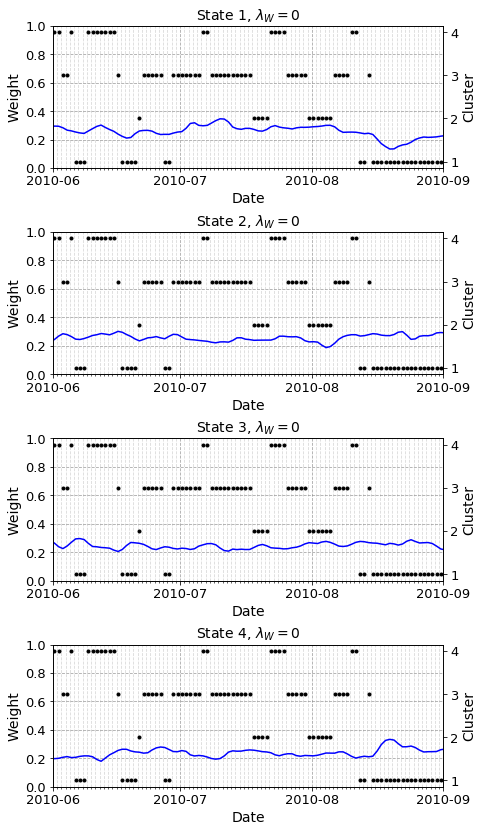

In [621]:
n_components = 4
lambda_W = 0
n_eofs = 167
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init, reference)
gpnh_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, lambda_W, n_init)

kmeans_ordering = get_pca_kmeans_centroids_ordering(kmeans_output_file, eofs_output_file)
gpnh_ordering = get_pca_gpnh_dictionary_ordering(gpnh_output_file, eofs_output_file)

kmeans_ds = xr.open_dataset(kmeans_output_file)
gpnh_ds = xr.open_dataset(gpnh_output_file)

kmeans_weights_da = kmeans_ds['weights']
gpnh_weights_da = gpnh_ds['weights']

kmeans_weights_da = apply_ordering(kmeans_weights_da, kmeans_ordering, sample_dim='cluster')
kmeans_labels = np.zeros((kmeans_ds.sizes[TIME_NAME],))
for j in range(n_components):
    mask = kmeans_weights_da.sel(cluster=j).values != 0
    kmeans_labels[mask] = j + 1

gpnh_weights_da = apply_ordering(gpnh_weights_da, gpnh_ordering, sample_dim='state')

components = np.arange(gpnh_ds.sizes['state'])

ncols = 1
nrows = int(np.ceil(n_components / ncols))

fig = plt.figure(constrained_layout=False, figsize=(7 * ncols, 3.5 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,
                       wspace=0.2, hspace=0.45)

for i, component in enumerate(components):
    weight_data = gpnh_weights_da.sel(state=component).values

    markers = itertools.cycle(('.', 'x', 's', 'd', '+', 'o'))

    ax = fig.add_subplot(gs[i, 0])

    ax.plot(gpnh_ds[TIME_NAME], weight_data, 'b-')

    labels_ax = ax.twinx()
    
    labels_ax.plot(kmeans_ds[TIME_NAME], kmeans_labels, color='k', marker='.', ls='none')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    labels_ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    labels_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    ax.grid(ls='--', color='gray', alpha=0.7)
    ax.grid(ls='--', color='gray', alpha=0.3, which='minor')

    ax.set_xlim(np.datetime64('2010-06-01'), np.datetime64('2010-09-01'))
    ax.set_ylim(0, 1)

    ax.tick_params(labelsize=13)
    labels_ax.tick_params(labelsize=13)

    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Weight', fontsize=14)

    labels_ax.set_ylabel('Cluster', fontsize=14)

    ax.set_title('State {}, $\lambda_W = {:d}$'.format(component + 1, lambda_W), fontsize=14)

output_filename = (os.path.splitext(os.path.basename(gpnh_output_file))[0] + '.weights.pdf')
output_file = os.path.join(PLOTS_DIR, output_filename)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

gpnh_ds.close()
kmeans_ds.close()

In [376]:
max_n_components = 20
lambda_W = 0
n_init = 100

pca_gpnh_k = []
pca_gpnh_cost = []
pca_gpnh_rmse = []

for i in range(1, max_n_components + 1):

    output_file = get_pca_gpnh_output_filename(eofs_output_file, i, lambda_W, n_init)
    
    with xr.open_dataset(output_file) as ds:
        
        pca_gpnh_k.append(ds.sizes['state'])
        pca_gpnh_cost.append(float(ds.attrs['cost']))
        pca_gpnh_rmse.append(float(ds.attrs['rmse']))
        
pca_gpnh_k = np.array(pca_gpnh_k)
pca_gpnh_cost = np.array(pca_gpnh_cost)
pca_gpnh_rmse = np.array(pca_gpnh_rmse)

cost_output_file = (os.path.splitext(os.path.basename(eofs_output_file))[0] +
                       'gpnh.lambda_W{:5.3e}.n_init{:d}.cost.csv'.format(lambda_W, n_init))
cost_output_file = os.path.join(CSV_DIR, cost_output_file)

cost_data = np.zeros((pca_gpnh_k.shape[0], 3))
cost_data[:, 0] = pca_gpnh_k
cost_data[:, 1] = pca_gpnh_cost
cost_data[:, 2] = pca_gpnh_rmse

header = 'n_components,cost,rmse'
fmt = '%d,%16.8e,%16.8e'

np.savetxt(cost_output_file, cost_data, header=header, fmt=fmt)

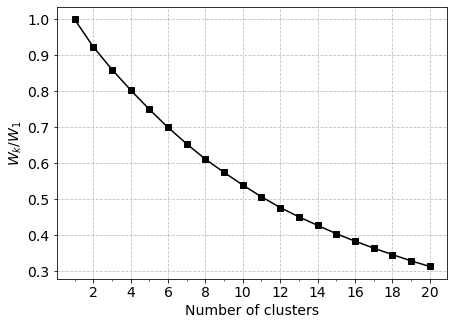

In [377]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(pca_gpnh_k, pca_gpnh_cost / pca_gpnh_cost[0], 'k-', marker='s')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('$W_k / W_1$', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

plt.show()

plt.close()

In [266]:
n_components = 3
lambda_W = 0.1
n_init = 100

pca_gpnh_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, lambda_W, n_init)

gpnh_ds = xr.open_dataset(pca_gpnh_output_file)
eofs_ds = xr.open_dataset(eofs_output_file)

pca_gpnh_dictionary_da = gpnh_ds['dictionary']
pca_gpnh_labels_da = gpnh_ds['weights']

pca_gpnh_dictionary_da = pca_gpnh_dictionary_da.rename({'state': TIME_NAME})

mds_2d_results = run_mds({'PCs': eofs_ds['PCs'].isel({TIME_NAME: slice(0, None, 10)}), 'dictionary': pca_gpnh_dictionary_da},
                         n_components=2, random_state=0, sample_dim=TIME_NAME)

eofs_ds.close()
gpnh_ds.close()

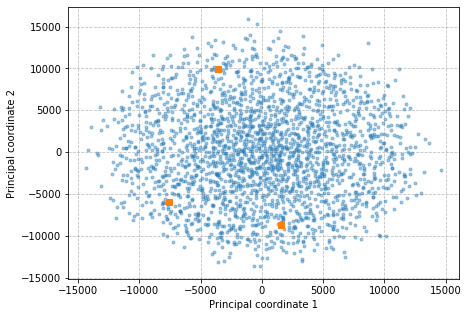

In [267]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

pcs_x_coords = mds_2d_results['PCs']['embedding'].sel(mds_coord=0).values
pcs_y_coords = mds_2d_results['PCs']['embedding'].sel(mds_coord=1).values

markers = itertools.cycle(('.', 's', 'x', 'o', '+', 'd'))

#cs = ax.hist2d(pcs_x_coords, pcs_y_coords, 10, density=False)[-1]
ax.plot(pcs_x_coords, pcs_y_coords, marker='.', ls='none', alpha=0.4)

dictionary_x_coords = mds_2d_results['dictionary']['embedding'].sel(mds_coord=0)
dictionary_y_coords = mds_2d_results['dictionary']['embedding'].sel(mds_coord=1)

ax.plot(dictionary_x_coords, dictionary_y_coords, 's', ls='none')
#cb = plt.colorbar(cs)
ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Principal coordinate 1')
ax.set_ylabel('Principal coordinate 2')

plt.show()

plt.close()

## Archetypal analysis of 500 hPa geopotential height anomalies

The final method we apply is ordinary archetypal analysis:

In [260]:
with open(os.path.join(BIN_DIR, 'run_jra55_pca_aa.py')) as ifs:
    for line in ifs:
        print(line.strip('\n'))

"""
Run archetypal analysis on PCs of JRA-55 500 hPa height anomalies.
"""

# License: MIT

from __future__ import absolute_import, division, print_function

import argparse
from copy import deepcopy
import time

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_random_state
import xarray as xr

from convex_dim_red import ArchetypalAnalysis


TIME_NAME = 'initial_time0_hours'

# First and last years to retain for analysis
START_YEAR = 1870
END_YEAR = 2018

# Number of random restarts to use
INIT = 'random'
N_INIT = 100

# Stopping criteria
MAX_ITERATIONS = 10000
TOLERANCE = 1e-6


def parse_cmd_line_args():
    """Parse command line arguments."""

    parser = argparse.ArgumentParser(
        description='Run archetypal analysis on PCs of JRA-55 500 hPa height anomalies'
    )

    parser.add_argument('input_file',
                        help='input file containing SST anomalies')
    parser.add_argument('output_file',
                  

In [261]:
def get_pca_aa_output_filename(input_file, n_components, delta, n_init):
    """Get AA output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    suffix = 'aa.k{:d}.delta{:5.3e}.n_init{:d}'.format(n_components, delta, n_init)
        
    return '.'.join([basename, suffix]) + ext

In [341]:
def get_aa_pca_dictionary(aa_filename, eofs_input_file,time_name=TIME_NAME, sort_by_eofs=True):
    """Reconstruct physical space dictionary vectors from PCs."""
    
    aa_ds = xr.open_dataset(aa_filename)

    eofs_ds = xr.open_dataset(eofs_input_file)
    
    dictionary = aa_ds['archetypes']

    dictionary_da = dictionary.dot(eofs_ds['EOFs'])
    
    if sort_by_eofs:
        dictionary_da = sort_states(dictionary_da, eofs_ds['EOFs'], sample_dim_one='archetype', sample_dim_two='component')
    
    aa_ds.close()
    eofs_ds.close()

    return dictionary_da

In [622]:
def get_aa_pca_dictionary_ordering(aa_filename, eofs_input_file,time_name=TIME_NAME):
    """Calculate fixed ordering for archetypes."""
    
    aa_ds = xr.open_dataset(aa_filename)

    eofs_ds = xr.open_dataset(eofs_input_file)
    
    dictionary = aa_ds['archetypes']

    dictionary_da = dictionary.dot(eofs_ds['EOFs'])
    
    ordering = sort_states(dictionary_da, eofs_ds['EOFs'], sample_dim_one='archetype', sample_dim_two='component', return_sort_order=True)
    
    aa_ds.close()
    eofs_ds.close()

    return ordering

In [279]:
max_n_components = 4
delta = 0
n_init = 100

pca_aa_k = []
pca_aa_cost = []
pca_aa_rmse = []

for i in range(1, max_n_components + 1):

    output_file = get_pca_aa_output_filename(eofs_output_file, i, delta, n_init)
    
    with xr.open_dataset(output_file) as ds:
        
        pca_aa_k.append(ds.sizes['archetype'])
        pca_aa_cost.append(float(ds.attrs['cost']))
        pca_aa_rmse.append(float(ds.attrs['rmse']))
        
pca_aa_k = np.array(pca_aa_k)
pca_aa_cost = np.array(pca_aa_cost)
pca_aa_rmse = np.array(pca_aa_rmse)

cost_output_file = (os.path.splitext(os.path.basename(eofs_output_file))[0] +
                       'aa.delta{:5.3e}.n_init{:d}.cost.csv'.format(delta, n_init))
cost_output_file = os.path.join(CSV_DIR, cost_output_file)

cost_data = np.zeros((pca_aa_k.shape[0], 3))
cost_data[:, 0] = pca_aa_k
cost_data[:, 1] = pca_aa_cost
cost_data[:, 2] = pca_aa_rmse

header = 'n_components,cost,rmse'
fmt = '%d,%16.8e,%16.8e'

np.savetxt(cost_output_file, cost_data, header=header, fmt=fmt)

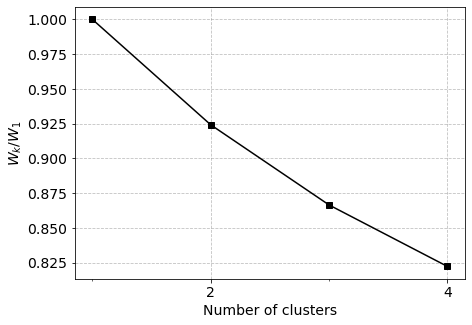

In [280]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(pca_aa_k, pca_aa_cost / pca_aa_cost[0], 'k-', marker='s')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('$W_k / W_1$', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

plt.show()

plt.close()

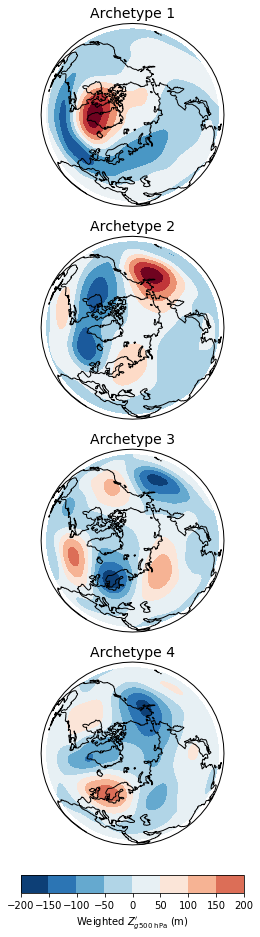

In [631]:
n_components = 4
delta = 0
n_eofs = 167
n_init = 100

aa_output_file = get_pca_aa_output_filename(eofs_output_file, n_components, delta, n_init)

aa_dictionary_da = get_aa_pca_dictionary(aa_output_file, eofs_output_file, sort_by_eofs=True)

components = aa_dictionary_da['archetype'].values

projection = ccrs.Orthographic(central_latitude=90, central_longitude=40)
wrap_lon = True

cmap = plt.cm.RdBu_r

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = aa_dictionary_da.sel(archetype=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = aa_dictionary_da.sel(archetype=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 1 #2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)

lat = aa_dictionary_da[LAT_NAME]
lon = aa_dictionary_da[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    archetype_data = aa_dictionary_da.sel(archetype=component).values

    if wrap_lon:
        archetype_data, archetype_lon = add_cyclic_point(archetype_data, coord=lon)
    else:
        archetype_lon = lon

    lon_grid, lat_grid = np.meshgrid(archetype_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, archetype_data, vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    ax.set_title('Archetype {}'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

cb_ax = fig.add_subplot(gs[-1, :])
cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')
cb.set_label('Weighted $Z_{g500\;\mathrm{hPa}}^\prime$ (m)')

output_filename = (os.path.splitext(os.path.basename(aa_output_file))[0] + '.archetypes.pdf')
output_file = os.path.join(PLOTS_DIR, output_filename)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

<xarray.DataArray 'weights' (initial_time0_hours: 92, archetype: 4)>
array([[0.296112, 0.349866, 0.214817, 0.139205],
       [0.405288, 0.277368, 0.168771, 0.148573],
       [0.454064, 0.222006, 0.140311, 0.183618],
       ...,
       [0.18954 , 0.228076, 0.215976, 0.366408],
       [0.269542, 0.16528 , 0.189182, 0.375995],
       [0.326559, 0.089554, 0.206967, 0.37692 ]])
Coordinates:
  * initial_time0_hours  (initial_time0_hours) datetime64[ns] 2010-06-01T09:00:00 ... 2010-08-31T09:00:00
  * archetype            (archetype) int32 0 1 2 3
<xarray.DataArray (archetype: 4, initial_time0_hours: 92)>
array([[1.39205299e-01, 1.48572846e-01, 1.83618334e-01, 2.21123019e-01,
        2.25946434e-01, 2.46569957e-01, 2.68410235e-01, 2.81611083e-01,
        2.39921226e-01, 1.99794419e-01, 1.49024344e-01, 1.25714207e-01,
        1.83321158e-01, 2.34173128e-01, 2.77253152e-01, 3.46525846e-01,
        3.86116219e-01, 3.98239570e-01, 3.72008455e-01, 3.02308467e-01,
        2.51442077e-01, 2.46656840e

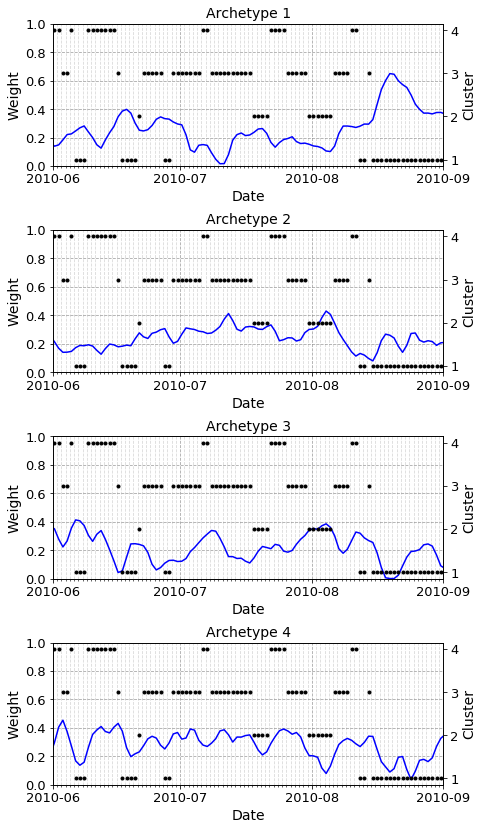

In [628]:
n_components = 4
delta = 0
n_eofs = 167
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init, reference)
aa_output_file = get_pca_aa_output_filename(eofs_output_file, n_components, delta, n_init)

kmeans_ordering = get_pca_kmeans_centroids_ordering(kmeans_output_file, eofs_output_file)
aa_ordering = get_aa_pca_dictionary_ordering(aa_output_file, eofs_output_file)

kmeans_ds = xr.open_dataset(kmeans_output_file)
aa_ds = xr.open_dataset(aa_output_file)

kmeans_weights_da = kmeans_ds['weights']
aa_weights_da = aa_ds['weights']

kmeans_weights_da = apply_ordering(kmeans_weights_da, kmeans_ordering, sample_dim='cluster')
kmeans_labels = np.zeros((kmeans_ds.sizes[TIME_NAME],))
for j in range(n_components):
    mask = kmeans_weights_da.sel(cluster=j).values != 0
    kmeans_labels[mask] = j + 1

print(aa_weights_da.sel({TIME_NAME: slice(np.datetime64('2010-06-01'), np.datetime64('2010-09-01'))}))
aa_weights_da = apply_ordering(aa_weights_da, aa_ordering, sample_dim='archetype')
print(aa_weights_da.sel({TIME_NAME: slice(np.datetime64('2010-06-01'), np.datetime64('2010-09-01'))}))
components = np.arange(aa_ds.sizes['archetype'])

ncols = 1
nrows = int(np.ceil(n_components / ncols))

fig = plt.figure(constrained_layout=False, figsize=(7 * ncols, 3.5 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,
                       wspace=0.2, hspace=0.45)

for i, component in enumerate(components):
    weight_data = aa_weights_da.sel(archetype=component).values

    markers = itertools.cycle(('.', 'x', 's', 'd', '+', 'o'))

    ax = fig.add_subplot(gs[i, 0])

    ax.plot(aa_ds[TIME_NAME], weight_data, 'b-')

    labels_ax = ax.twinx()
    
    labels_ax.plot(kmeans_ds[TIME_NAME], kmeans_labels, color='k', marker='.', ls='none')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    labels_ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    labels_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    ax.grid(ls='--', color='gray', alpha=0.7)
    ax.grid(ls='--', color='gray', alpha=0.3, which='minor')

    ax.set_xlim(np.datetime64('2010-06-01'), np.datetime64('2010-09-01'))
    ax.set_ylim(0, 1)

    ax.tick_params(labelsize=13)
    labels_ax.tick_params(labelsize=13)

    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Weight', fontsize=14)

    labels_ax.set_ylabel('Cluster', fontsize=14)

    ax.set_title('Archetype {}'.format(component + 1), fontsize=14)

output_filename = (os.path.splitext(os.path.basename(aa_output_file))[0] + '.weights.pdf')
output_file = os.path.join(PLOTS_DIR, output_filename)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

aa_ds.close()
kmeans_ds.close()

In [282]:
n_components = 4
delta = 0
n_init = 100

pca_aa_output_file = get_pca_aa_output_filename(eofs_output_file, n_components, delta, n_init)

aa_ds = xr.open_dataset(pca_aa_output_file)
eofs_ds = xr.open_dataset(eofs_output_file)

pca_aa_dictionary_da = aa_ds['archetypes']
pca_aa_labels_da = aa_ds['weights']

pca_aa_dictionary_da = pca_aa_dictionary_da.rename({'archetype': TIME_NAME})

mds_2d_results = run_mds({'PCs': eofs_ds['PCs'].isel({TIME_NAME: slice(0, None, 10)}), 'archetypes': pca_aa_dictionary_da},
                         n_components=2, random_state=0, sample_dim=TIME_NAME)

eofs_ds.close()
aa_ds.close()

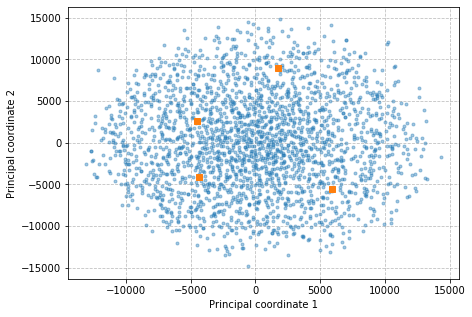

In [283]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

pcs_x_coords = mds_2d_results['PCs']['embedding'].sel(mds_coord=0).values
pcs_y_coords = mds_2d_results['PCs']['embedding'].sel(mds_coord=1).values

markers = itertools.cycle(('.', 's', 'x', 'o', '+', 'd'))

#cs = ax.hist2d(pcs_x_coords, pcs_y_coords, 10, density=False)[-1]
ax.plot(pcs_x_coords, pcs_y_coords, marker='.', ls='none', alpha=0.4)

dictionary_x_coords = mds_2d_results['archetypes']['embedding'].sel(mds_coord=0)
dictionary_y_coords = mds_2d_results['archetypes']['embedding'].sel(mds_coord=1)

ax.plot(dictionary_x_coords, dictionary_y_coords, 's', ls='none')
#cb = plt.colorbar(cs)
ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Principal coordinate 1')
ax.set_ylabel('Principal coordinate 2')

plt.show()

plt.close()

## Combined results

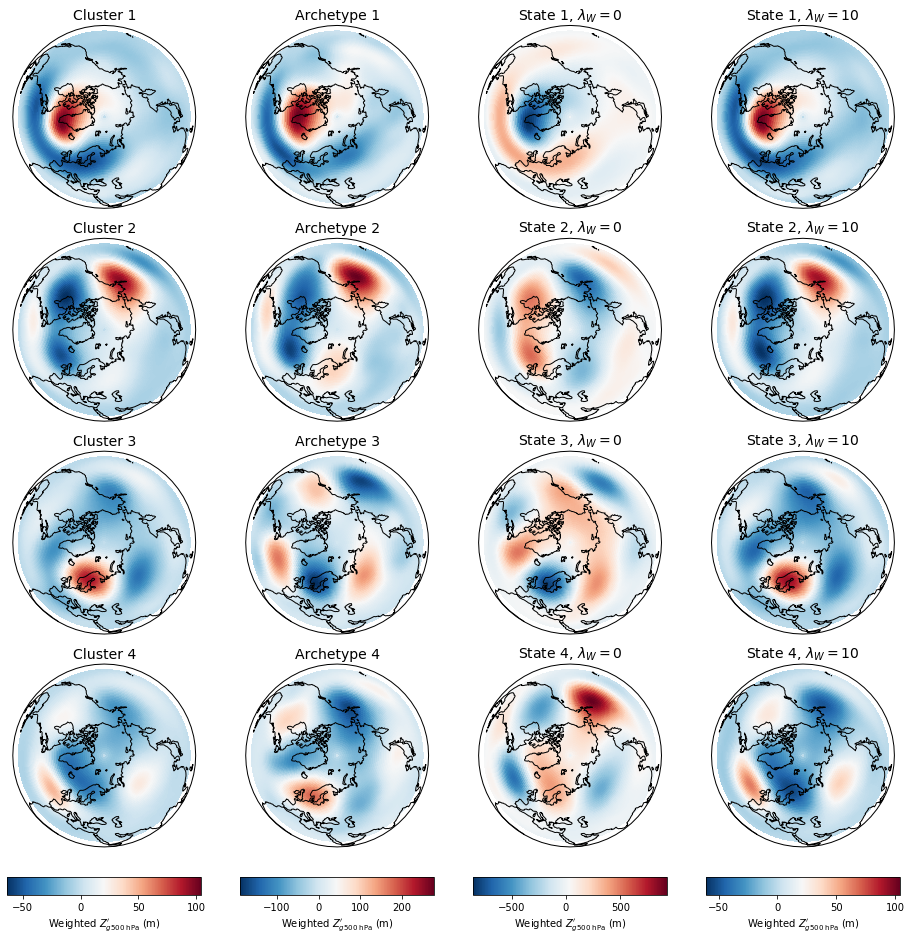

In [392]:
n_components = 4
lambda_W = 10
delta = 0
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init, reference)
aa_output_file = get_pca_aa_output_filename(eofs_output_file, n_components, delta, n_init)
gpnh_no_reg_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, 0, n_init)
gpnh_reg_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, lambda_W, n_init)

kmeans_dictionary_da = get_kmeans_pca_centroids(kmeans_output_file, eofs_output_file)
aa_dictionary_da = get_aa_pca_dictionary(aa_output_file, eofs_output_file)
gpnh_no_reg_dictionary_da = get_gpnh_pca_dictionary(gpnh_no_reg_output_file, eofs_output_file)
gpnh_reg_dictionary_da = get_gpnh_pca_dictionary(gpnh_reg_output_file, eofs_output_file)

patterns = {'kmeans': kmeans_dictionary_da,
            'archetypes': aa_dictionary_da.rename(archetype='cluster'),
            'gpnh_no_reg': gpnh_no_reg_dictionary_da.rename(state='cluster'),
            'gpnh_reg': gpnh_reg_dictionary_da.rename(state='cluster')}

components = np.arange(n_components)

projection = ccrs.Orthographic(central_latitude=90, central_longitude=40)
wrap_lon = True

cmap = plt.cm.RdBu_r

ncols = 4
nrows = n_components
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(4 * ncols, 4 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.2,
                       height_ratios=height_ratios)


for i, method in enumerate(patterns):
    patterns_da = patterns[method]

    lat = patterns_da[LAT_NAME]
    lon = patterns_da[LON_NAME]

    component_vmins = np.empty(n_components)
    vmin = None
    for k in components:
        component_vmin = patterns_da.sel(cluster=k).min().item()
        if vmin is None or component_vmin < vmin:
            vmin = component_vmin

    component_vmins[:] = vmin

    component_vmaxs = np.empty(n_components)
    vmax = None
    for k in components:
        component_vmax = patterns_da.sel(cluster=k).max().item()
        if vmax is None or component_vmax > vmax:
            vmax = component_vmax

    component_vmaxs[:] = vmax

    for component in components:
        pattern_data = patterns_da.sel(cluster=component).values

        if wrap_lon:
            pattern_data, pattern_lon = add_cyclic_point(pattern_data, coord=lon)
        else:
            pattern_lon = lon

        lon_grid, lat_grid = np.meshgrid(pattern_lon, lat)

        ax = fig.add_subplot(gs[component, i], projection=projection)

        ax.coastlines()
        ax.set_global()

        ax_vmin = component_vmins[component]
        ax_vmax = component_vmaxs[component]

        cs = ax.pcolor(lon_grid, lat_grid, pattern_data, vmin=ax_vmin, vmax=ax_vmax,
                       cmap=cmap, transform=ccrs.PlateCarree())

        if method == 'kmeans':
            ax.set_title('Cluster {}'.format(component + 1), fontsize=14)
        elif method == 'archetypes':
            ax.set_title('Archetype {}'.format(component + 1), fontsize=14)
        elif method == 'gpnh_no_reg':
            ax.set_title('State {}, $\lambda_W = 0$'.format(component + 1), fontsize=14)
        else:
            ax.set_title('State {}, $\lambda_W = {:d}$'.format(component + 1, lambda_W), fontsize=14)

        ax.set_aspect('equal')
        fig.canvas.draw()

    cb_ax = fig.add_subplot(gs[-1, i])
    cb = fig.colorbar(cs, cax=cb_ax, pad=0.05, orientation='horizontal')
    cb.set_label('Weighted $Z_{g500\;\mathrm{hPa}}^\prime$ (m)')

output_filename = (os.path.splitext(os.path.basename(eofs_output_file))[0] + '.combined.k{:d}.patterns.pdf'.format(n_components))
output_file = os.path.join(PLOTS_DIR, output_filename)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

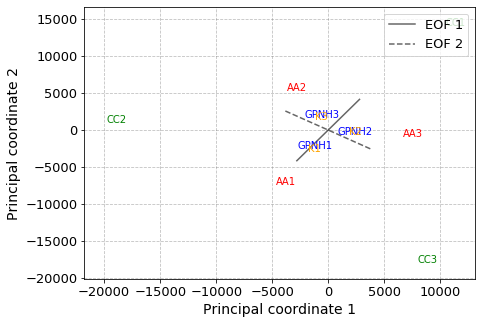

In [680]:
n_components = 3
lambda_W = 10
delta = 0
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init, reference)
aa_output_file = get_pca_aa_output_filename(eofs_output_file, n_components, delta, n_init)
gpnh_no_reg_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, 0, n_init)
gpnh_reg_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, lambda_W, n_init)

aa_patterns = get_aa_pca_dictionary(aa_output_file, eofs_output_file)
gpnh_no_reg_patterns = get_gpnh_pca_dictionary(gpnh_no_reg_output_file, eofs_output_file)
gpnh_reg_patterns = get_gpnh_pca_dictionary(gpnh_reg_output_file, eofs_output_file)
kmeans_patterns = get_kmeans_pca_centroids(kmeans_output_file, eofs_output_file)

eofs_ds = xr.open_dataset(eofs_output_file)

n_samples = eofs_ds.sizes[TIME_NAME]
n_test_points = 100

leading_max_magnitude = 3 * eofs_ds['singular_values'].sel(component=0) / (n_samples - 1) ** 0.5
leading_test_magnitudes = np.linspace(-leading_max_magnitude, leading_max_magnitude, n_test_points)

leading_test_vectors = np.array([leading_test_magnitudes[i] * eofs_ds['EOFs'].sel(component=0).values
                                 for i in range(n_test_points)])

leading_test_vectors_da = xr.DataArray(
    leading_test_vectors,
    coords={'cluster': np.arange(100),
            LAT_NAME: eofs_ds[LAT_NAME].values,
            LON_NAME: eofs_ds[LON_NAME].values},
    dims=['cluster', LAT_NAME, LON_NAME])

subleading_max_magnitude = 3 * eofs_ds['singular_values'].sel(component=1) / (n_samples - 1) ** 0.5
subleading_test_magnitudes = np.linspace(-subleading_max_magnitude, subleading_max_magnitude, n_test_points)

subleading_test_vectors = np.array([subleading_test_magnitudes[i] * eofs_ds['EOFs'].sel(component=1).values
                                    for i in range(n_test_points)])

subleading_test_vectors_da = xr.DataArray(
    subleading_test_vectors,
    coords={'cluster': np.arange(100),
            LAT_NAME: eofs_ds[LAT_NAME].values,
            LON_NAME: eofs_ds[LON_NAME].values},
    dims=['cluster', LAT_NAME, LON_NAME])

eofs_ds.close()

mds_2d_scos_results = run_mds({'kmeans': kmeans_patterns,
                               'archetypes': aa_patterns.rename(archetype='cluster'),
                               'gpnh_no_reg': gpnh_no_reg_patterns.rename(state='cluster'),
                               'gpnh_reg': gpnh_reg_patterns.rename(state='cluster'),
                               'leading_principal_vector': leading_test_vectors_da,
                               'subleading_principal_vector': subleading_test_vectors_da,
                              },
                              n_components=2, random_state=0, sample_dim='cluster')

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

x_min = None
x_max = None
y_min = None
y_max = None

archetype_x_coords = mds_2d_scos_results['archetypes']['embedding'].sel(mds_coord=0).values
archetype_y_coords = mds_2d_scos_results['archetypes']['embedding'].sel(mds_coord=1).values

if x_min is None or np.min(archetype_x_coords) < x_min:
    x_min = np.min(archetype_x_coords)

if x_max is None or np.max(archetype_x_coords) > x_max:
    x_max = np.max(archetype_x_coords)

if y_min is None or np.min(archetype_y_coords) < y_min:
    y_min = np.min(archetype_y_coords)

if y_max is None or np.max(archetype_y_coords) > y_max:
    y_max = np.max(archetype_y_coords)

# ax.plot(mds_2d_scos_results['archetypes']['embedding'].sel(mds_coord=0),
#         mds_2d_scos_results['archetypes']['embedding'].sel(mds_coord=1), marker='none', label='Archetypes')

for i, coords in enumerate(zip(archetype_x_coords, archetype_y_coords)):
    ax.text(coords[0], coords[1], 'AA{:d}'.format(i + 1),
            color='red', fontsize=10, ha='center', va='center')

gpnh_no_reg_x_coords = mds_2d_scos_results['gpnh_no_reg']['embedding'].sel(mds_coord=0).values
gpnh_no_reg_y_coords = mds_2d_scos_results['gpnh_no_reg']['embedding'].sel(mds_coord=1).values

if x_min is None or np.min(gpnh_no_reg_x_coords) < x_min:
    x_min = np.min(gpnh_no_reg_x_coords)

if x_max is None or np.max(gpnh_no_reg_x_coords) > x_max:
    x_max = np.max(gpnh_no_reg_x_coords)

if y_min is None or np.min(gpnh_no_reg_y_coords) < y_min:
    y_min = np.min(gpnh_no_reg_y_coords)

if y_max is None or np.max(gpnh_no_reg_y_coords) > y_max:
    y_max = np.max(gpnh_no_reg_y_coords)

# # ax.plot(mds_2d_scos_results['gpnh_no_reg']['embedding'].sel(mds_coord=0),
# #         mds_2d_scos_results['gpnh_no_reg']['embedding'].sel(mds_coord=1), 's', label='GPNH, $\lambda_W = 0$')
for i, coords in enumerate(zip(gpnh_no_reg_x_coords, gpnh_no_reg_y_coords)):
    ax.text(coords[0], coords[1], 'CC{:d}'.format(i + 1),
            color='green', fontsize=10, ha='center', va='center')

gpnh_reg_x_coords = mds_2d_scos_results['gpnh_reg']['embedding'].sel(mds_coord=0).values
gpnh_reg_y_coords = mds_2d_scos_results['gpnh_reg']['embedding'].sel(mds_coord=1).values

if x_min is None or np.min(gpnh_reg_x_coords) < x_min:
    x_min = np.min(gpnh_reg_x_coords)

if x_max is None or np.max(gpnh_reg_x_coords) > x_max:
    x_max = np.max(gpnh_reg_x_coords)

if y_min is None or np.min(gpnh_reg_y_coords) < y_min:
    y_min = np.min(gpnh_reg_y_coords)

if y_max is None or np.max(gpnh_reg_y_coords) > y_max:
    y_max = np.max(gpnh_reg_y_coords)

# # ax.plot(mds_2d_scos_results['gpnh_reg']['embedding'].sel(mds_coord=0),
# #         mds_2d_scos_results['gpnh_reg']['embedding'].sel(mds_coord=1), 'o', label='GPNH, $\lambda_W = {:.2f}$'.format(lambda_W))
for i, coords in enumerate(zip(gpnh_reg_x_coords, gpnh_reg_y_coords)):
    ax.text(coords[0], coords[1], 'GPNH{:d}'.format(i + 1),
            color='blue', fontsize=10, ha='center', va='center')

kmeans_x_coords = mds_2d_scos_results['kmeans']['embedding'].sel(mds_coord=0).values
kmeans_y_coords = mds_2d_scos_results['kmeans']['embedding'].sel(mds_coord=1).values

if x_min is None or np.min(kmeans_x_coords) < x_min:
    x_min = np.min(kmeans_x_coords)

if x_max is None or np.max(kmeans_x_coords) > x_max:
    x_max = np.max(kmeans_x_coords)

if y_min is None or np.min(kmeans_y_coords) < y_min:
    y_min = np.min(kmeans_y_coords)

if y_max is None or np.max(kmeans_y_coords) > y_max:
    y_max = np.max(kmeans_y_coords)

# # ax.plot(mds_2d_scos_results['kmeans']['embedding'].sel(mds_coord=0),
# #         mds_2d_scos_results['kmeans']['embedding'].sel(mds_coord=1), 'x', label='k-means')
for i, coords in enumerate(zip(kmeans_x_coords, kmeans_y_coords)):
    ax.text(coords[0], coords[1], 'K{:d}'.format(i + 1),
            color='orange', fontsize=10, ha='center', va='center')

ax.plot(mds_2d_scos_results['leading_principal_vector']['embedding'].sel(mds_coord=0).values,
        mds_2d_scos_results['leading_principal_vector']['embedding'].sel(mds_coord=1).values, 'k-',
        label='EOF 1', alpha=0.6)
ax.plot(mds_2d_scos_results['subleading_principal_vector']['embedding'].sel(mds_coord=0).values,
        mds_2d_scos_results['subleading_principal_vector']['embedding'].sel(mds_coord=1).values, 'k--',
        label='EOF 2', alpha=0.6)

# ax.plot(mds_2d_scos_results['archetypes']['origin'].sel(mds_coord=0),
#         mds_2d_scos_results['archetypes']['origin'].sel(mds_coord=1), 'ko', markersize=8,
#         alpha=0.5, label='Mean state')

ax.grid(ls='--', color='gray', alpha=0.5)
ax.legend(fontsize=13)

ax.set_xlim(1.15 * x_min, 1.15 * x_max)
ax.set_ylim(1.15 * y_min, 1.15 * y_max)

ax.set_xlabel('Principal coordinate 1', fontsize=14)
ax.set_ylabel('Principal coordinate 2', fontsize=14)
ax.axes.tick_params(labelsize=13)

output_filename = (os.path.splitext(os.path.basename(eofs_output_file))[0] + '.combined.k{:d}.mds.pdf'.format(n_components))
output_file = os.path.join(PLOTS_DIR, output_filename)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

gpnh_no_reg_ds.close()
gpnh_reg_ds.close()
kmeans_ds.close()

In [448]:
def simplex_plot(kmeans_labels_da, weights_da, archetypes_da,  sample_dim=TIME_NAME):

    n_components = archetypes_da.sizes['archetype']
    archetype_coords = np.zeros((n_components, 2))
    for i in range(n_components):
        archetype_coords[i, 0] = np.cos(2 * pi * (i + 1) / n_components)
        archetype_coords[i, 1] = np.sin(2 * pi * (i + 1) / n_components)

    sample_weights = weight_and_flatten_data(weights_da, sample_dim=sample_dim)
    sample_coords = sample_weights.dot(archetype_coords)

    fig = plt.figure(figsize=(7, 5))
    ax = plt.gca()
    
    ax.plot(archetype_coords[:, 0], archetype_coords[:, 1], 'ko')
    
    markers = itertools.cycle(('.', 's', 'x', 'o', 'd'))
    n_clusters = kmeans_labels_da.sizes['cluster']
    
    for k in range(n_clusters):
        mask = kmeans_labels_da.sel(cluster=k).values != 0
        ax.plot(sample_coords[mask, 0], sample_coords[mask, 1], marker=next(markers), ls='none', alpha=0.4)
        
    mask = np.logical_and((weights_da[sample_dim] >= np.datetime64('2010-07-01')).values,
                          (weights_da[sample_dim] < np.datetime64('2010-08-01')).values)
    print(mask)
    ax.plot(sample_coords[mask, 0], sample_coords[mask, 1], color='k')
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    plt.show()
    
    plt.close()

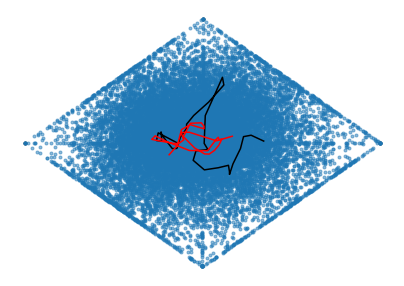

In [575]:
n_components = 4
delta = 0
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init, reference)
aa_output_file = get_pca_aa_output_filename(eofs_output_file, n_components, delta, n_init)

kmeans_ds = xr.open_dataset(kmeans_output_file)
aa_ds = xr.open_dataset(aa_output_file)

archetype_coords = np.zeros((n_components, 2))

for i in range(n_components):
    archetype_coords[i, 0] = np.cos(2 * pi * (i + 1) / n_components)
    archetype_coords[i, 1] = np.sin(2 * pi * (i + 1) / n_components)

sample_weights = weight_and_flatten_data(aa_ds['weights'])
sample_coords = sample_weights.dot(archetype_coords)

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()
    
ax.plot(archetype_coords[:, 0], archetype_coords[:, 1], 'k.', markerfacecolor='k')

ax.plot(sample_coords[:, 0], sample_coords[:, 1], '.', alpha=0.5)

mask = np.logical_and((aa_ds[TIME_NAME] >= np.datetime64('2003-07-01')).values,
                      (aa_ds[TIME_NAME] < np.datetime64('2003-08-01')).values)
mask2 = np.logical_and((aa_ds[TIME_NAME] >= np.datetime64('2010-07-01')).values,
                      (aa_ds[TIME_NAME] < np.datetime64('2010-08-01')).values)

ax.plot(sample_coords[mask, 0], sample_coords[mask, 1], color='k')
ax.plot(sample_coords[mask2, 0], sample_coords[mask2, 1], color='r')

ax.axis('off')

plt.show()

plt.close()

aa_ds.close()
kmeans_ds.close()

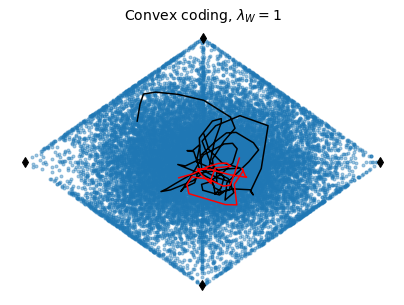

In [576]:
n_components = 4
lambda_W = 1
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init, reference)
gpnh_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, lambda_W, n_init)

kmeans_ds = xr.open_dataset(kmeans_output_file)
gpnh_ds = xr.open_dataset(gpnh_output_file)

dictionary_coords = np.zeros((n_components, 2))

for i in range(n_components):
    dictionary_coords[i, 0] = np.cos(2 * pi * (i + 1) / n_components)
    dictionary_coords[i, 1] = np.sin(2 * pi * (i + 1) / n_components)

sample_weights = weight_and_flatten_data(gpnh_ds['weights'])
sample_coords = sample_weights.dot(dictionary_coords)

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(sample_coords[:, 0], sample_coords[:, 1], '.', alpha=0.4)

mask = np.logical_and((gpnh_ds[TIME_NAME] >= np.datetime64('2003-06-01')).values,
                      (gpnh_ds[TIME_NAME] < np.datetime64('2003-09-01')).values)
mask2 = np.logical_and((gpnh_ds[TIME_NAME] >= np.datetime64('2010-07-01')).values,
                      (gpnh_ds[TIME_NAME] < np.datetime64('2010-08-01')).values)

ax.plot(sample_coords[mask, 0], sample_coords[mask, 1], color='k')
ax.plot(sample_coords[mask2, 0], sample_coords[mask2, 1], color='r')

ax.plot(dictionary_coords[:, 0], dictionary_coords[:, 1], 'kd', markerfacecolor='k', markersize=7)

ax.set_title('Convex coding, $\lambda_W = {:d}$'.format(lambda_W), fontsize=14)

ax.axis('off')

plt.show()

plt.close()

gpnh_ds.close()
kmeans_ds.close()

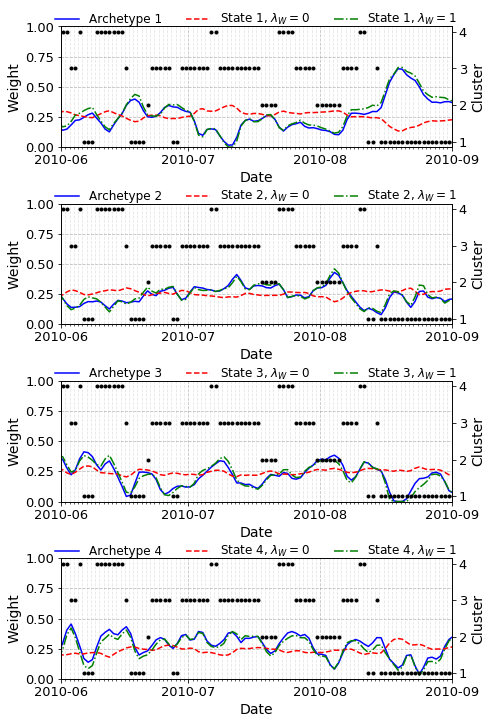

In [663]:
n_components = 4
delta = 0
lambda_W = 1
n_eofs = 167
n_init = 100
reference = 'pca'

kmeans_output_file = get_pca_kmeans_output_filename(eofs_output_file, n_components, n_init, reference)
gpnh_no_reg_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, 0, n_init)
gpnh_reg_output_file = get_pca_gpnh_output_filename(eofs_output_file, n_components, lambda_W, n_init)
aa_output_file = get_pca_aa_output_filename(eofs_output_file, n_components, delta, n_init)

kmeans_ordering = get_pca_kmeans_centroids_ordering(kmeans_output_file, eofs_output_file)
aa_ordering = get_aa_pca_dictionary_ordering(aa_output_file, eofs_output_file)
gpnh_no_reg_ordering = get_pca_gpnh_dictionary_ordering(gpnh_no_reg_output_file, eofs_output_file)
gpnh_reg_ordering = get_pca_gpnh_dictionary_ordering(gpnh_reg_output_file, eofs_output_file)

kmeans_ds = xr.open_dataset(kmeans_output_file)
aa_ds = xr.open_dataset(aa_output_file)
gpnh_no_reg_ds = xr.open_dataset(gpnh_no_reg_output_file)
gpnh_reg_ds = xr.open_dataset(gpnh_reg_output_file)

kmeans_weights_da = kmeans_ds['weights']
aa_weights_da = aa_ds['weights']
gpnh_no_reg_weights_da = gpnh_no_reg_ds['weights']
gpnh_reg_weights_da = gpnh_reg_ds['weights']

kmeans_weights_da = apply_ordering(kmeans_weights_da, kmeans_ordering, sample_dim='cluster')
kmeans_labels = np.zeros((kmeans_ds.sizes[TIME_NAME],))
for j in range(n_components):
    mask = kmeans_weights_da.sel(cluster=j).values != 0
    kmeans_labels[mask] = j + 1


aa_weights_da = apply_ordering(aa_weights_da, aa_ordering, sample_dim='archetype')
gpnh_no_reg_weights_da = apply_ordering(gpnh_no_reg_weights_da, gpnh_no_reg_ordering, sample_dim='state')
gpnh_reg_weights_da = apply_ordering(gpnh_reg_weights_da, gpnh_reg_ordering, sample_dim='state')

components = np.arange(aa_ds.sizes['archetype'])

ncols = 1
nrows = int(np.ceil(n_components / ncols))

fig = plt.figure(constrained_layout=False, figsize=(7 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,
                       wspace=0.2, hspace=0.47)

for i, component in enumerate(components):
    aa_weight_data = aa_weights_da.sel(archetype=component).values
    gpnh_no_reg_weight_data = gpnh_no_reg_weights_da.sel(state=component).values
    gpnh_reg_weight_data = gpnh_reg_weights_da.sel(state=component).values

    markers = itertools.cycle(('.', 'x', 's', 'd', '+', 'o'))

    ax = fig.add_subplot(gs[i, 0])

    ax.plot(aa_ds[TIME_NAME], aa_weight_data, 'b-', label='Archetype {:d}'.format(component + 1))
    ax.plot(gpnh_no_reg_ds[TIME_NAME], gpnh_no_reg_weight_data, 'r--',
            label='State {:d}, $\lambda_W = 0$'.format(component + 1))
    ax.plot(gpnh_reg_ds[TIME_NAME], gpnh_reg_weight_data, 'g-.',
            label='State {:d}, $\lambda_W = {:d}$'.format(component + 1, lambda_W))

    labels_ax = ax.twinx()
    
    labels_ax.plot(kmeans_ds[TIME_NAME], kmeans_labels, color='k', marker='.', ls='none')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())

    labels_ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    labels_ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    ax.grid(ls='--', color='gray', alpha=0.5)
    ax.grid(ls='--', color='gray', alpha=0.2, which='minor')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.21), ncol=3,
              fontsize=12, frameon=False, fancybox='none')

    ax.set_xlim(np.datetime64('2010-06-01'), np.datetime64('2010-09-01'))
    ax.set_ylim(0, 1)

    ax.tick_params(labelsize=13)
    labels_ax.tick_params(labelsize=13)

    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Weight', fontsize=14)

    labels_ax.set_ylabel('Cluster', fontsize=14)


output_filename = (os.path.splitext(os.path.basename(eofs_output_file))[0] +
                   '.combined.k{:d}.weights.pdf'.format(n_components))
output_file = os.path.join(PLOTS_DIR, output_filename)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

aa_ds.close()
gpnh_no_reg_ds.close()
gpnh_reg_ds.close()
kmeans_ds.close()